<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsione della Qualità dell'Aria in India

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets

In [1]:
import os
import requests
import zipfile
import io
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output
from sklearn.ensemble import IsolationForest

N_JOBS = -1
RANDOM_STATE = 42

!apt-get update -qq
!apt-get install -qq git-lfs
!git lfs install
!git clone https://github.com/vMxster/Data_Project.git
!cd Data_Project && git lfs pull

# India Dataset

zip_india_path   = "Data_Project/Datasets/dataset_india.zip"
india_extract_to = "datasets/india"
os.makedirs(india_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_india_path, 'r') as z:
    z.extractall(india_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(india_extract_to):
    for f in files:
        print(os.path.join(root, f))

# Cina Dataset

zip_china_path   = "Data_Project/Datasets/dataset_china.zip"
china_extract_to = "datasets/china"
os.makedirs(china_extract_to, exist_ok=True)

with zipfile.ZipFile(zip_china_path, 'r') as z:
    z.extractall(china_extract_to)

print("\nEstratti:\n")
for root, _, files in os.walk(china_extract_to):
    for f in files:
        print(os.path.join(root, f))


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
Cloning into 'Data_Project'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 5), reused 22 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 4.36 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Filtering content: 100% (2/2), 472.65 MiB | 15.25 MiB/s, done.

Estratti:

datasets/india/UP041.csv
datasets/india/KA027.csv
datasets/india/OR001.csv
datasets/india/WB007.csv
datasets/india/RJ034.csv
datasets/india/UP022.csv
datasets/india/DL040.csv
datasets/india/UP013.csv
datasets/india/AR001.csv
datasets/india/PB004.csv
datasets/india/UP001.csv
datasets/india/WB004.csv
datasets/india/CG007.csv
datasets/india/UP021.csv
datasets/india/MP022.csv
data

# Dataset sulla **Qualità dell'Aria in India**



Il dataset in questione è stato messo a disposizione dal Central Pollution Control Board (CPCB), l’ente ufficiale del Governo indiano deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria in 453 città indiane nel periodo compreso tra il 2010 e il 2023.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO e CO₂: rispettivamente monossido e anidride carbonica, misurati in vari formati (mg/m³, ppm, ecc.);
- NO, NO₂ e NOx: varianti degli ossidi di azoto, riportati in unità adatte (ug/m³, ppb, ppm);
- SO₂, NH₃ e altri inquinanti quali Benzene, CH₄, e composti organici come MP-Xylene, Eth-Benzene, O Xylene, e Xylene;
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, umidità relativa, velocità e direzione del vento, radiazione solare e precipitazioni.

In aggiunta al dataset principale, è disponibile anche il file “stations_info.csv”, che rappresenta una guida di riferimento per approfondire le informazioni relative alle diverse stazioni di monitoraggio. Questo file include le seguenti intestazioni:

- file_name: nome del file associato alla stazione;
- state: lo stato in cui è ubicata la stazione;
- city: la città in cui la stazione opera;
- agency: l’ente responsabile della gestione della stazione;
- station_location: dettagli aggiuntivi riguardanti la posizione;
- start_month, start_month_num e start_year: informazioni sulla data di inizio della raccolta dati per ciascuna stazione.

Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [2]:
df_states = pd.read_csv(f'{india_extract_to}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

file_name           state               city  start_month_num  start_year
0     AP001  Andhra Pradesh           Tirupati                7        2016
1     AP002  Andhra Pradesh         Vijayawada                5        2017
2     AP003  Andhra Pradesh      Visakhapatnam                7        2017
3     AP004  Andhra Pradesh  Rajamahendravaram                9        2017
4     AP005  Andhra Pradesh          Amaravati               11        2017

Si crea una lista di tutti gli stati presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [3]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

Questa funzione consente di raccogliere, integrare e unificare dati relativi alla qualità dell’aria provenienti da più file CSV associati a diverse località di un determinato stato. La strategia prevede innanzitutto l’individuazione automatica di tutti i file relativi ad uno specifico stato, grazie all’utilizzo di un codice identificativo presente all’inizio del nome di ciascun file. Una volta selezionati i file pertinenti, il contenuto di ciascuno viene letto e trasformato in una struttura dati standardizzata. Durante questo processo, viene aggiunta ad ogni insieme di dati un’informazione supplementare che indica la città di appartenenza, garantendo così che ogni record contenga il riferimento geografico completo. Alla fine, i singoli dataset vengono combinati in un’unica struttura dati, offrendo un quadro complessivo che facilita un’analisi omogenea e dettagliata delle tendenze e delle variabili relative alla qualità dell’aria all’interno dello stato esaminato.

In [4]:
def combine_state_df(state_name):
    state_code = df_states[df_states['state'] == state_name]['file_name'].iloc[0][:2]
    state_files = glob.glob(f'{india_extract_to}/{state_code}*.csv')

    combined_df = []

    for state_file in state_files:
        file_name = state_file.split(f'{india_extract_to}/')[1][0:-4]
        file_df = pd.read_csv(state_file)
        file_df['city'] = df_states[df_states['file_name'] == file_name]['city'].values[0]
        file_df['city'] = file_df['city'].astype('string')
        combined_df.append(file_df)

    return pd.concat(combined_df)

In [5]:
df = combine_state_df('Delhi')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2796171 entries, 0 to 104440
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  BP (mmHg)            float64
 19  Xylene (ug/m3)       float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 string 
 23  CO (ug/m3)           float64
 24  Tolu

Dall’analisi del dataframe risulta che per lo stato di Delhi sono presenti 58 metriche diverse distribuite su un totale di 2.796.171 record.

## Pre-elaborazione dei dati

#### Utilizzo di ‘From Date’ come indice temporale

Nel dataset sono presenti due colonne di tipo oggetto, `From Date` e `To Date`, che indicano l’inizio e la fine di ciascuna finestra oraria di misurazione. Per gestire efficacemente le serie storiche, trasformiamo `From Date` in un indice datetime, eliminando poi la colonna `To Date`.

In [6]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [7]:
df = create_dt_index(df)
df.head(2)

PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
datetime                                                                    
2020-11-13 14:00:00         142.70        390.00        0.57        17.92   
2020-11-13 15:00:00         130.43        326.85        1.58        17.61   

                     NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
datetime                                                               
2020-11-13 14:00:00      18.48        48.87         2.78        0.83   
2020-11-13 15:00:00      19.19        56.64         2.69        0.71   

                     Ozone (ug/m3)  Benzene (ug/m3)  ...  Xylene ()  \
datetime                                             ...              
2020-11-13 14:00:00          39.24              2.4  ...        NaN   
2020-11-13 15:00:00          30.93              2.7  ...        NaN   

                     CO (ng/m3)  CH4 ()  CH4 (ug/m3)  NMHC (ug/m3)  \
datetime                                                             
2020-11-13 14:00:00         NaN     NaN          NaN           NaN   
2020-11-13 15:00:00         NaN     NaN          NaN           NaN   

                     SPM (ug/m3)  THC (ug/m3)  MH (m)  HCHO (ug/m3)  \
datetime                                                              
2020-11-13 14:00:00          NaN          NaN     NaN           NaN   
2020-11-13 15:00:00          NaN          NaN     NaN           NaN   

                     Hg (ug/m3)  
datetime                         
2020-11-13 14:00:00         NaN  
2020-11-13 15:00:00         NaN  

[2 rows x 58 columns]

### Feature Reduction

Dall’esame del dataframe emerge che alcune colonne contengono informazioni sovrapposte. Per individuare possibili duplicazioni e fusioni, confronteremo gli andamenti delle medie annuali delle variabili raggruppate. Per ciascun gruppo, aggregheremo i valori per anno e tracceremo un grafico a linee in una griglia, in modo da mettere in evidenza trend comuni e facilitare l’individuazione di correlazioni tra le feature.

In [8]:
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)

    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0

        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

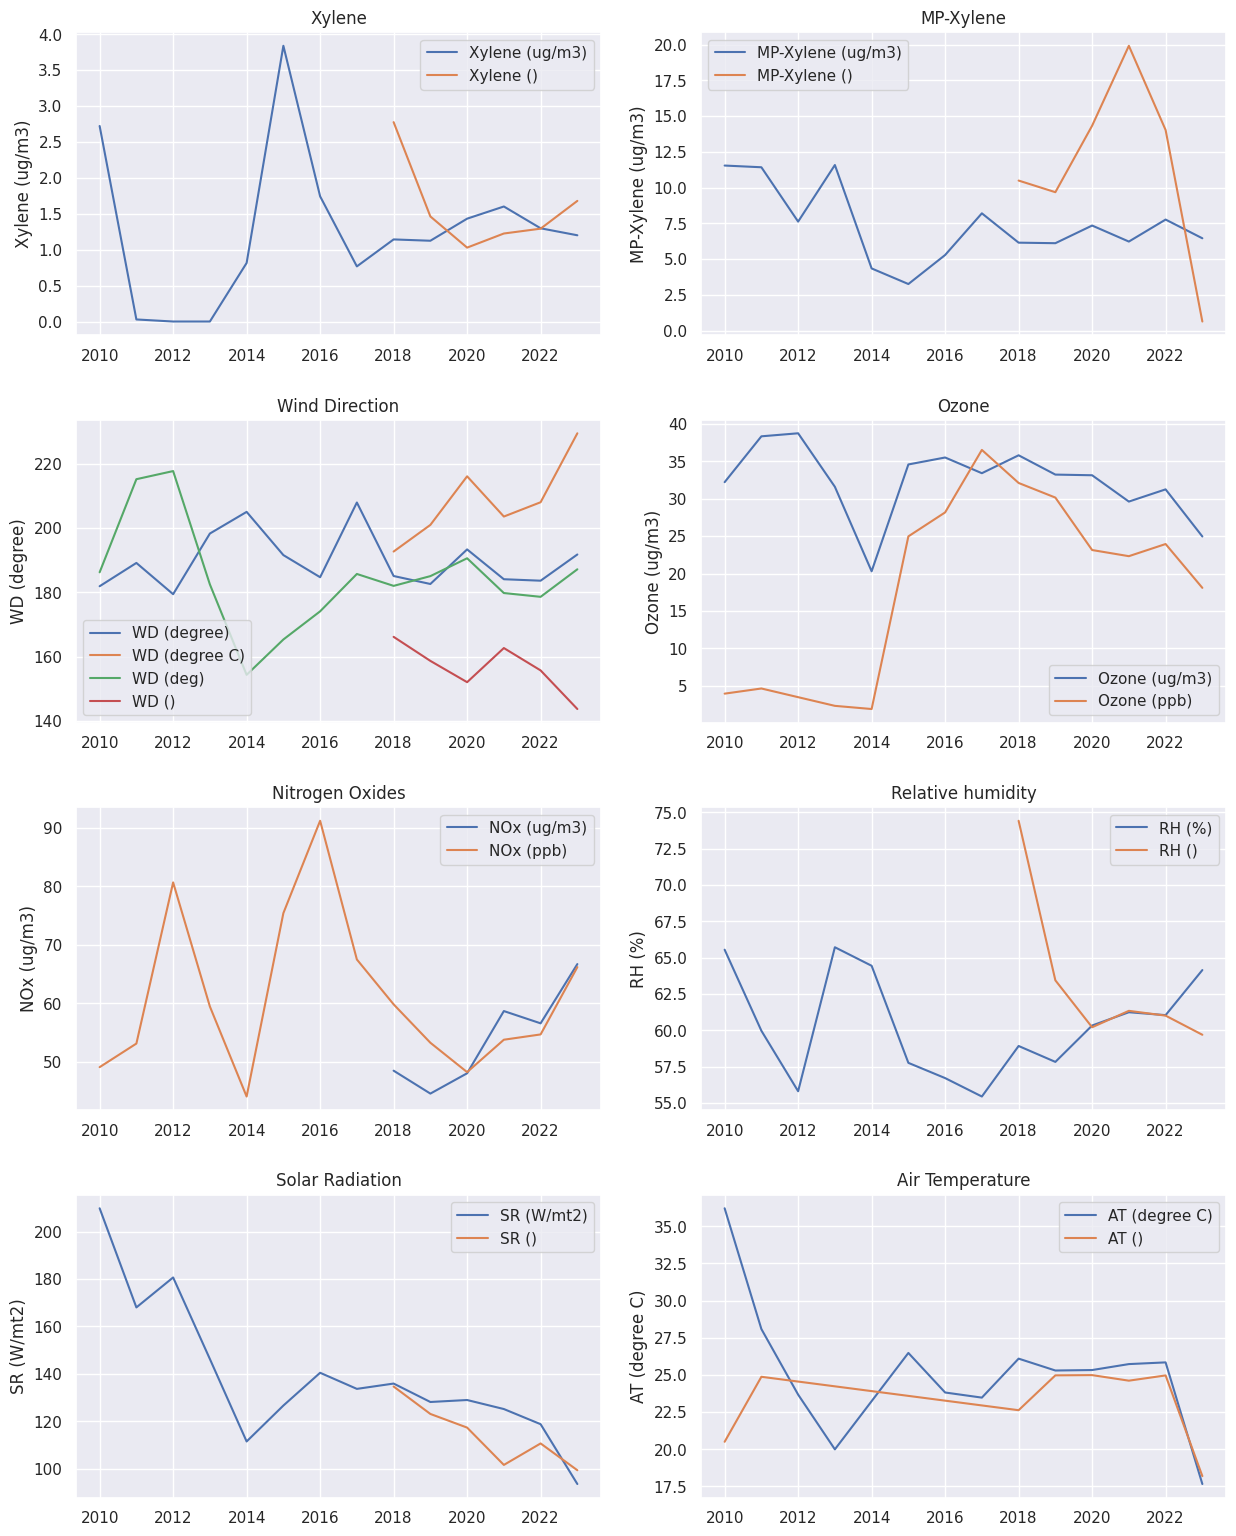

In [9]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':   ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative humidity':  ['RH (%)', 'RH ()'],
    'Solar Radiation': ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':  ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df, groups, columns=2)

Procediamo quindi con l’analisi descrittiva delle variabili raggruppate. Dopo aver raccolto in un’unica lista tutte le feature interessate, calcolo per ciascuna statistica di base — media, deviazione standard, valori minimo e massimo — formattando i risultati con tre decimali per migliorarne la leggibilità. Questo step permette di valutare rapidamente la scala e la distribuzione delle variabili, facilitando le decisioni su eventuali fusioni o eliminazioni di feature.


In [10]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().map(lambda x: f"{x:0.3f}")

Xylene (ug/m3)  Xylene () MP-Xylene (ug/m3) MP-Xylene () WD (degree)  \
count     242944.000  34578.000        264768.000    29205.000  813361.000   
mean           1.337      1.319             7.040       13.824     186.417   
std            5.762      3.348            13.603       19.986      94.905   
min            0.000      0.000             0.010        0.010       0.020   
25%            0.000      0.000             1.210        2.890     104.850   
50%            0.000      0.400             2.940        7.040     187.380   
75%            1.010      1.400             7.410       15.760     268.950   
max          476.310    231.000           491.510      286.010     360.000   

      WD (degree C)    WD (deg)       WD () Ozone (ug/m3) Ozone (ppb)  \
count     43888.000  655812.000  122463.000   1874697.000   47576.000   
mean        205.871     184.905     157.480        32.370      25.864   
std          88.418      80.286      91.992        34.778      19.535   
min           1.200       0.030       1.300         0.010       0.050   
25%         119.570     121.010      86.950         8.550      13.530   
50%         230.435     185.310     147.830        19.600      20.480   
75%         285.550     252.050     229.700        43.150      33.130   
max         356.520     359.590     359.700       200.000     198.470   

      NOx (ug/m3)    NOx (ppb)       RH (%)      RH ()   SR (W/mt2)  \
count   86086.000  1876466.000  1611483.000  39722.000  1555347.000   
mean       52.076       56.894       59.893     62.812      130.106   
std        59.768       70.730       22.548     20.497      180.273   
min         0.100        0.000        0.010      0.820        0.000   
25%        17.380       16.980       43.120     46.450        5.580   
50%        31.050       31.680       61.330     63.820       29.500   
75%        61.100       64.280       78.000     80.000      216.210   
max       498.850      500.000      100.000     99.200     1995.000   

           SR () AT (degree C)      AT ()  
count  43267.000   1110834.000  83016.000  
mean     116.041        25.136     24.178  
std      172.197         8.561      8.426  
min        2.720         0.100      1.880  
25%        3.480        18.580     17.420  
50%       11.350        26.400     25.380  
75%      174.735        31.500     30.300  
max      836.420        58.900     56.270

Dopo aver esaminato in dettaglio la tabella, avvio la riduzione delle colonne duplicate aggregando quelle che rappresentano la stessa variabile con nomi diversi. Per farlo definisco un dizionario in cui ogni chiave è il nome unificato della variabile e i valori sono le etichette alternative. La funzione itera sul dizionario, trasferendo i valori non nulli dalle colonne secondarie a quella principale e cancellando infine le colonne ridondanti. Questo passaggio semplifica il dataset, eliminando le duplicazioni e facilitando le analisi future.

In [11]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [12]:
def merge_columns(dataframe, columns):
    for column, cols_to_merge in columns.items():
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])

    return dataframe

In [13]:
df = merge_columns(df, reduction_groups)

### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [14]:
df.isnull().sum().sort_values(ascending=False)

Eth-Benzene ()         2796171
Gust (m/s)             2796171
CO2 (mg/m3)            2796171
Power (W)              2796171
NMHC (ug/m3)           2796171
SPM (ug/m3)            2796171
Temp (ug/m3)           2796171
Gust (kl/h)            2796171
Variance (n)           2796171
Gust (km/hr)           2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene (ug/m3)        1262858
SR (W/mt2)             1240824
WS (m/s)               1199313
RH (%)                 1184688
PM10 (ug/m3)           1168542
WD (degree)            1160647
SO2 (ug/m3)            1121753
CO (mg/m3)             1070972
PM2.5 (ug/m3)           939895
Ozone (ug/m3)           873898
NOx (ug/m3)             833619
NO (ug/m3)              821483
NO2 (ug/m3)             783452
city                         0
dtype: int64

In [15]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [16]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

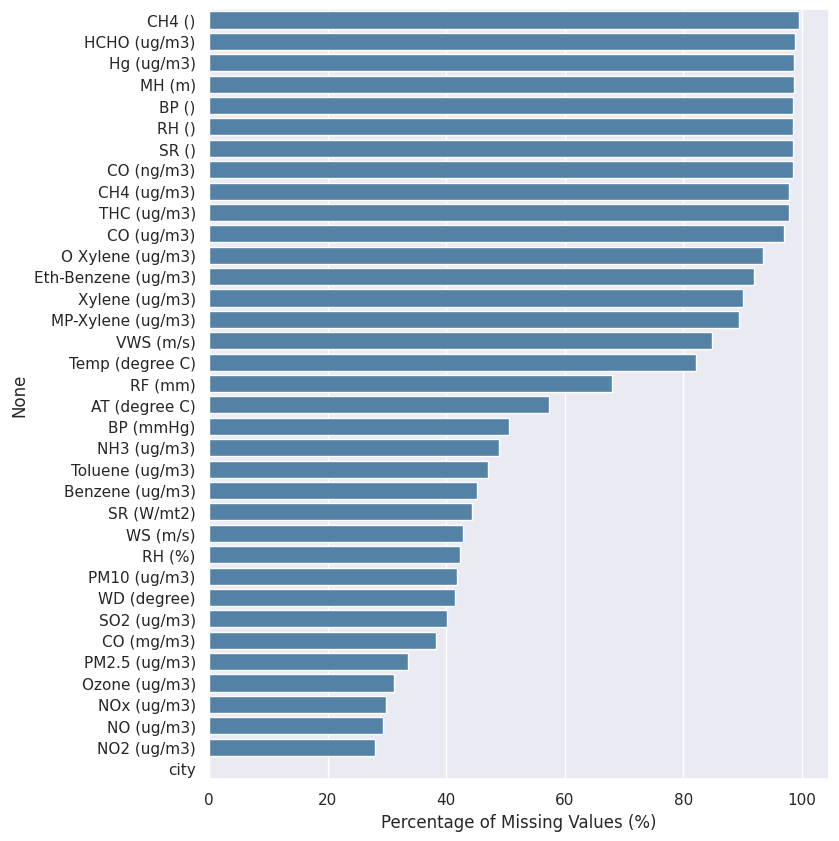

In [17]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percentage of Missing Values (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

### Informazioni sul numero dei valori mancanti del dataset

Finora abbiamo analizzato solo un singolo stato. Potremmo avere una migliore percezione dei dati mancanti se analizzassimo l'intero Dataset.

In [18]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        clear_output(wait=False)

        temp_df = combine_state_df(state_name)
        temp_df = create_dt_index(temp_df)
        temp_df = temp_df.dropna(how='all')

        comparisons = get_null_info(temp_df)

        total_records += df.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]

    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percentage of Missing Values (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info

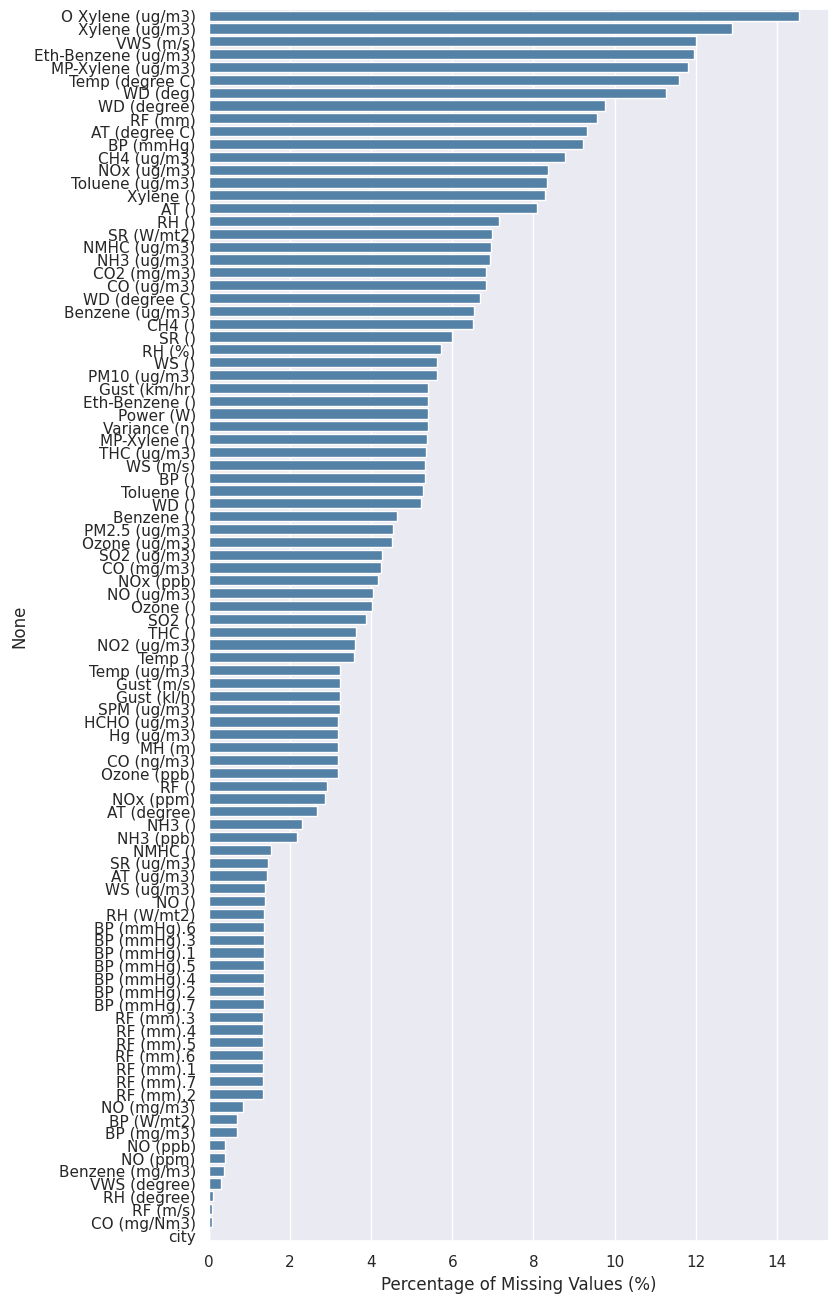

In [19]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percentage of Missing Values (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Tornando al dataframe della capitale Delhi, possiamo eliminare le colonne che contengono una certa soglia (cioè > 40%) di valori mancanti.

In [20]:
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [21]:
get_null_info(df)

Null Count  Percentage of Missing Values (%)
CO (mg/m3)        1070972                             38.30
PM2.5 (ug/m3)      939895                             33.61
Ozone (ug/m3)      873898                             31.25
NOx (ug/m3)        833619                             29.81
NO (ug/m3)         821483                             29.38
NO2 (ug/m3)        783452                             28.02
city                    0                              0.00

### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [22]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],
    'Carbon Monoxide': ['CO (mg/m3)'],
    'Sulfur Dioxide': ['SO2 (ug/m3)'],
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    'Solar Radiation' : ['SR (W/mt2)'],
    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],
    'Relative Humidity' : ['RH (%)'],
    'Rainfall' : ['RF (mm)'],
    'Barometric Pressure' : ['BP (mmHg)'],
    'Wind Direction' : ['WD (degree)'],
    'Wind Speed' : ['WS (m/s)']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [23]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [24]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

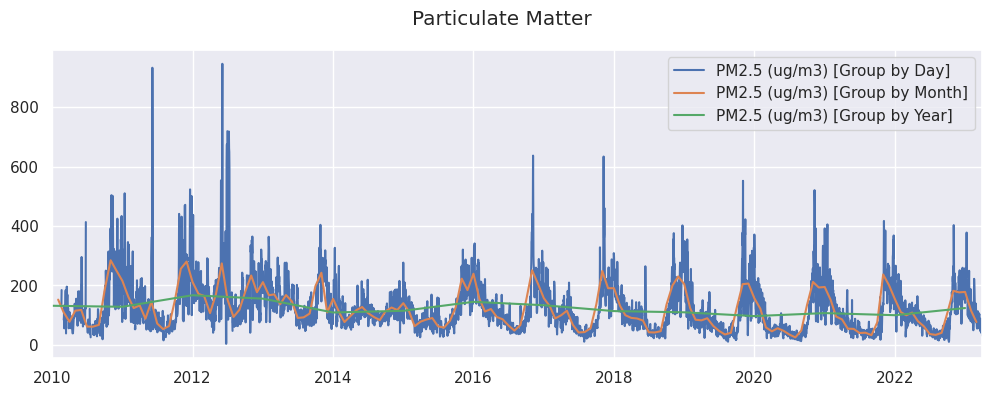

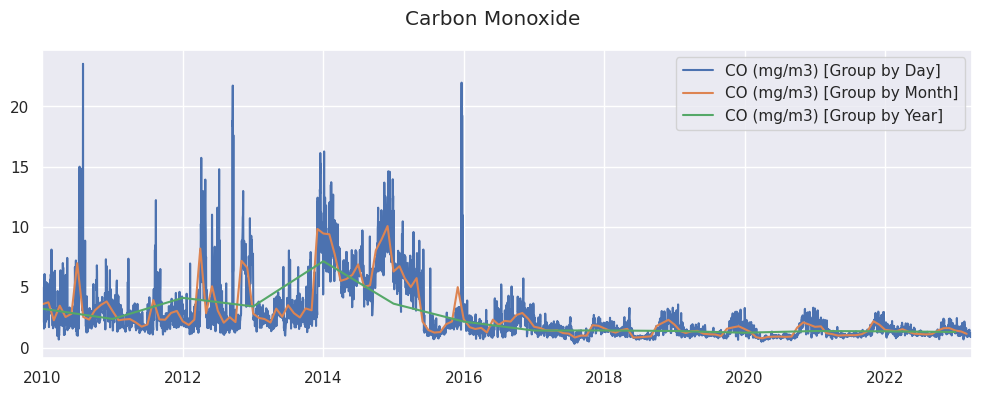

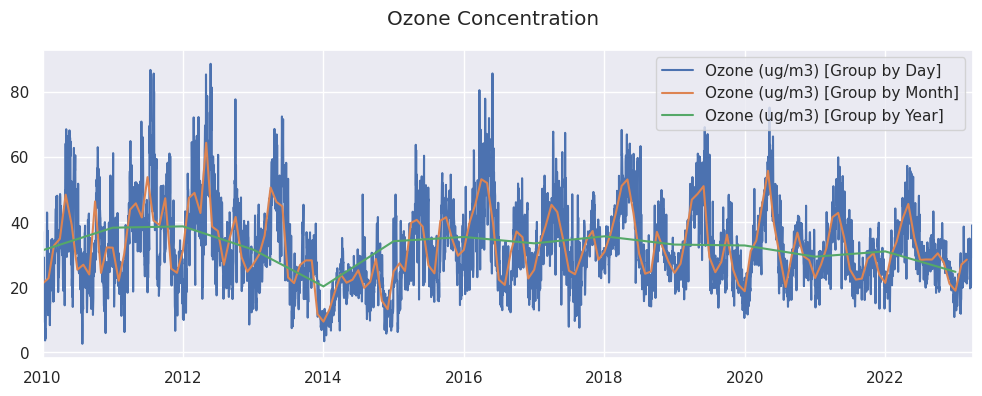

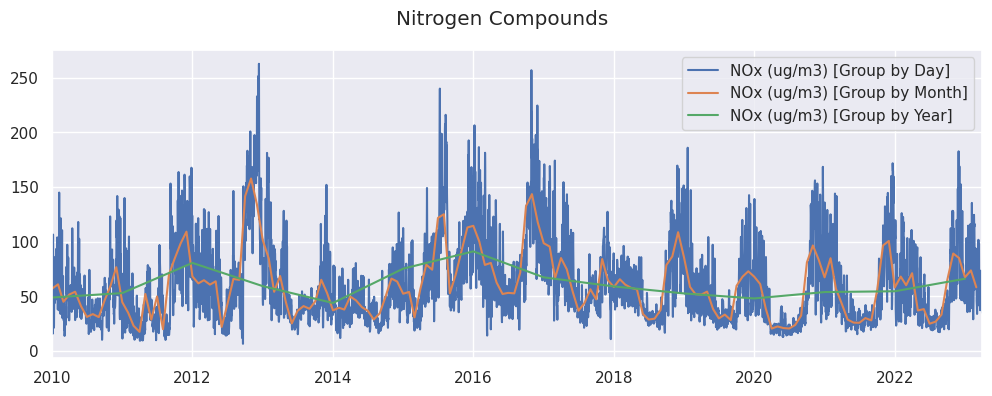

In [25]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2019–2020.

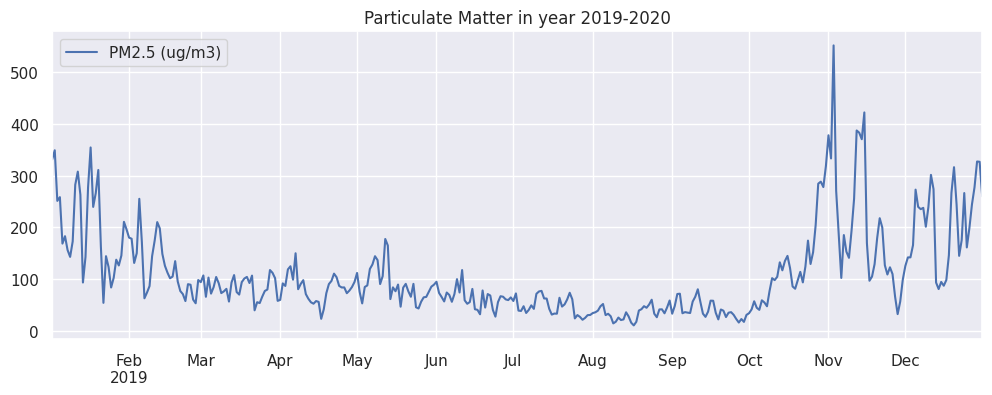

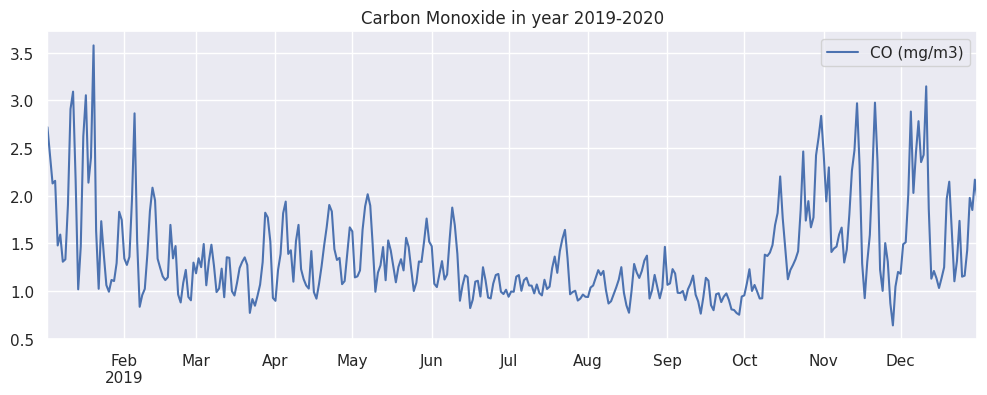

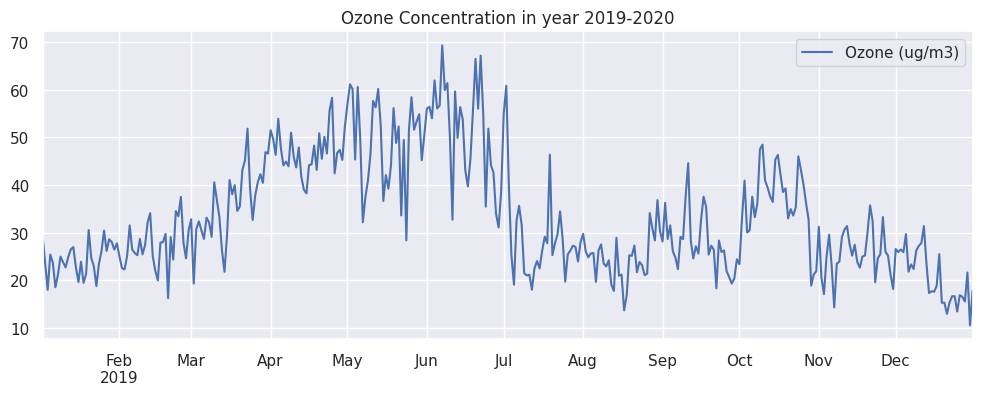

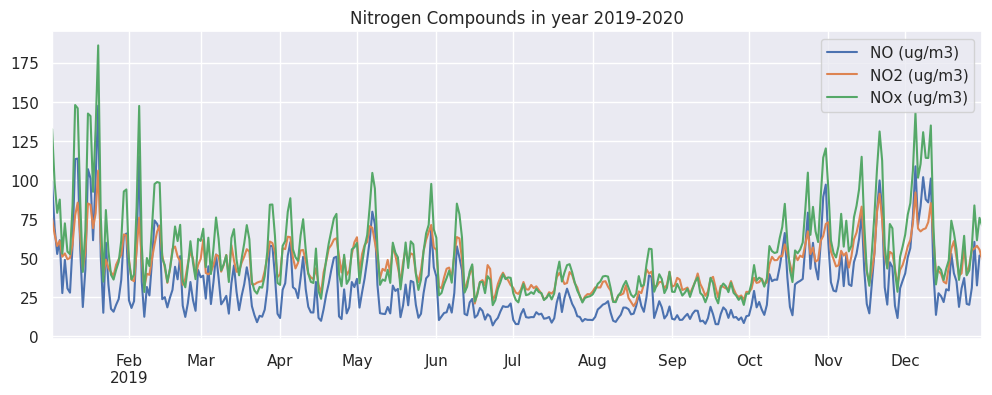

In [26]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

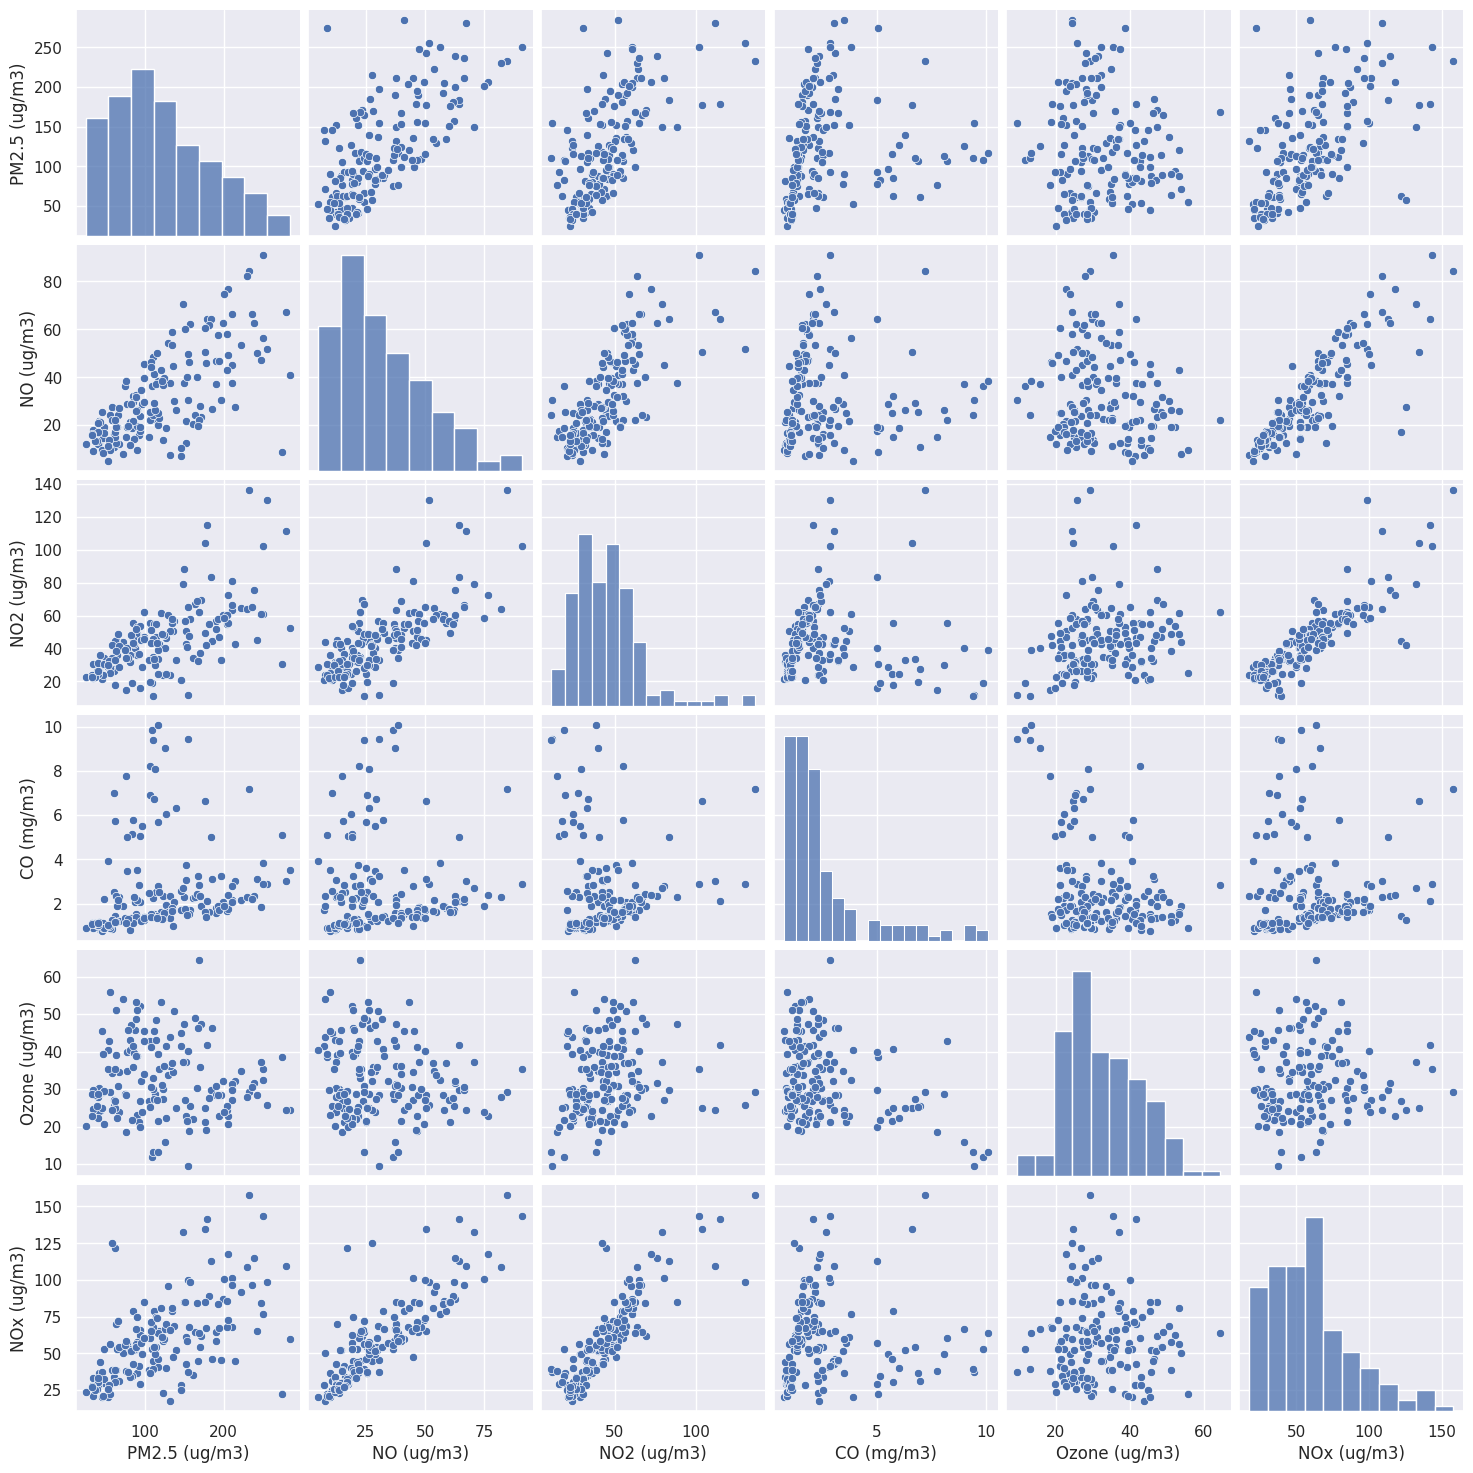

In [27]:
sns.pairplot(slice_groups['Group by Month'])

È evidente una correlazione lineare significativa tra `NOx`, `NO` e `NO2`. Considerando questa relazione, può essere opportuno mantenere esclusivamente la variabile aggregata `NOx` come rappresentazione generale del gruppo.

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

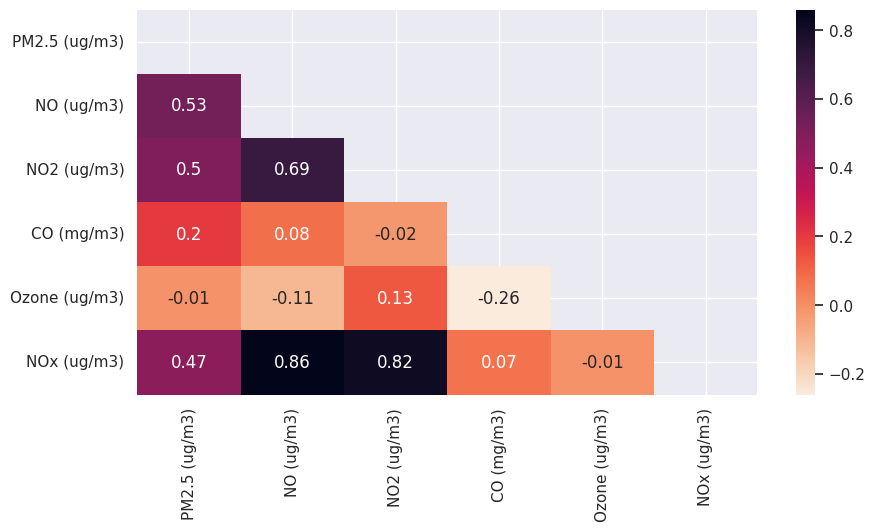

In [28]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [29]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ug/m3)      0.47
Name: PM2.5 (ug/m3), dtype: float64

Il grafico evidenzia diverse correlazioni significative tra le variabili. In particolare:

- `NOx` mostra una forte correlazione con le variabili `NO` e `NO2`.
- È inoltre evidente una relazione positiva tra `PM2.5` e `NOx`, suggerendo che all’aumentare dei valori di `NOx`, tendono ad aumentare anche i livelli di `PM2.5`.

## Feature Engineering

### Eliminazione delle Feature correlate

In [30]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [31]:
df = df.resample('60min').mean(numeric_only=True)

### Isolation Forest - Rilevamento e Rimozione degli Outlier
In questa sequenza di celle utilizzeremo l'algoritmo Isolation Forest per identificare e rimuovere gli outlier, che rappresentano valori anomali che si discostano in modo significativo dalla distribuzione generale dei dati. La loro presenza può compromettere l’accuratezza delle analisi statistiche e influenzare negativamente le prestazioni dei modelli predittivi. L’identificazione e la rimozione degli outlier consente di ottenere risultati più affidabili e modelli previsionali più robusti.

Definiamo le colonne su cui vogliamo applicare l'Isolation Forest.

In [32]:
features = ['PM2.5 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'NOx (ug/m3)']
df_features = df[features].copy()

Creiamo il modello specificando la proporzione di outlier attesi (`contamination`).

In [33]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df_features)

IsolationForest(contamination=0.01, random_state=42)

Usiamo il metodo `predict` per assegnare -1 agli outlier e 1 ai punti normali.

In [34]:
df['anomaly'] = iso.predict(df_features)

Creiamo un nuovo DataFrame senza gli outlier identificati.

In [35]:
df_clean = df[df['anomaly'] == 1].drop(columns='anomaly')

Confrontiamo la distribuzione originale e quella ripulita per ogni feature.

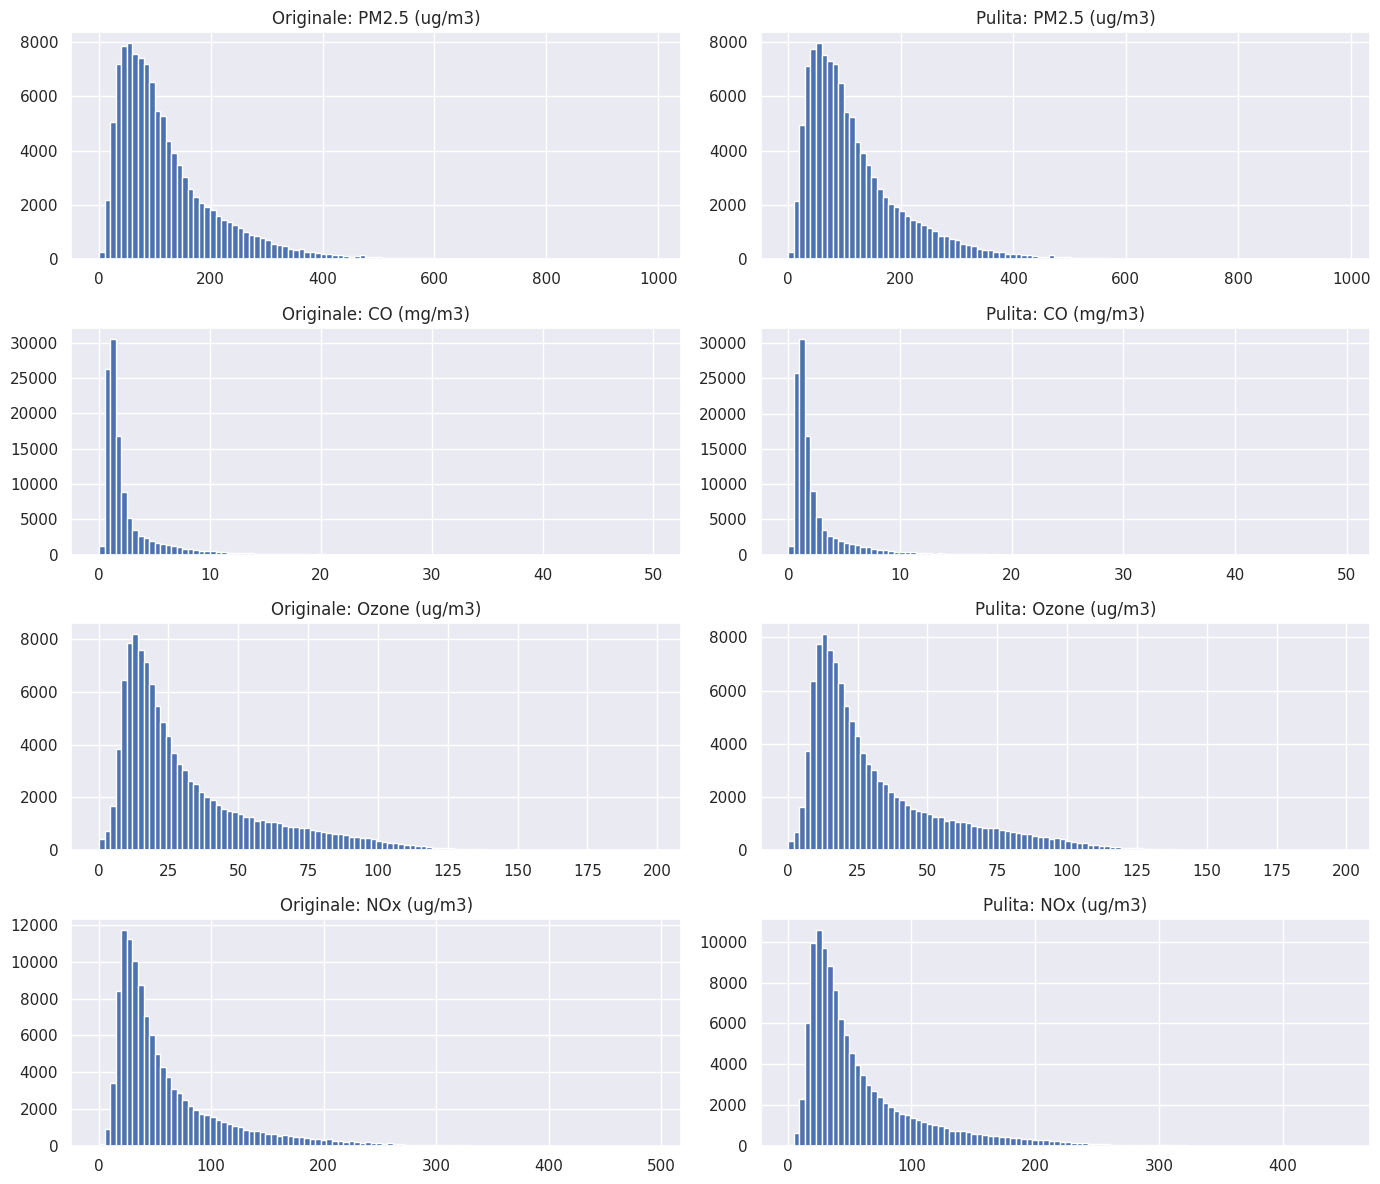

In [36]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for i, col in enumerate(features):
    # distribuzione originale
    axes[i, 0].hist(df[col].dropna(), bins=100)
    axes[i, 0].set_title(f"Originale: {col}")
    # distribuzione pulita
    axes[i, 1].hist(df_clean[col].dropna(), bins=100)
    axes[i, 1].set_title(f"Pulita: {col}")
plt.tight_layout()
plt.show()

df = df_clean.copy()

### Gestione dei valori mancanti

In [37]:
get_null_info(df)

Null Count  Percentage of Missing Values (%)
PM2.5 (ug/m3)        3825                              3.33
CO (mg/m3)           2090                              1.82
Ozone (ug/m3)          62                              0.05
NOx (ug/m3)            49                              0.04

In [38]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114950 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  114950 non-null  float64
 1   CO (mg/m3)     114950 non-null  float64
 2   Ozone (ug/m3)  114950 non-null  float64
 3   NOx (ug/m3)    114950 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


<ipython-input-38-0620f09ed20c>:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [39]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [40]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [41]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

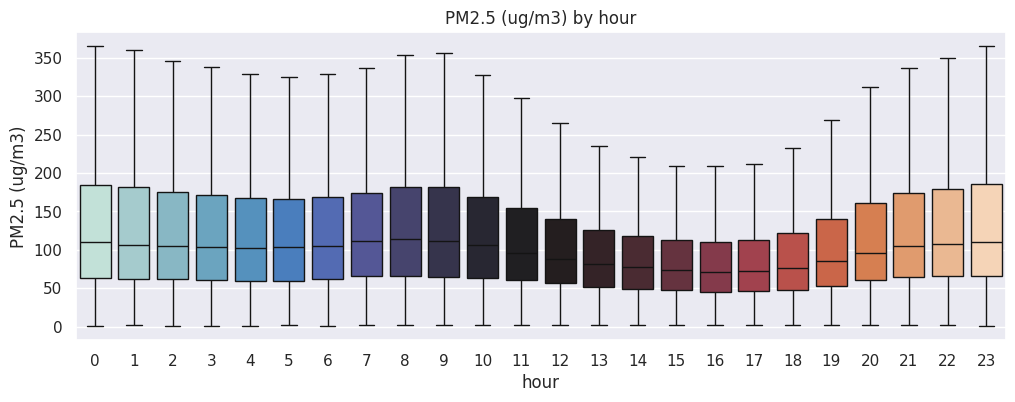

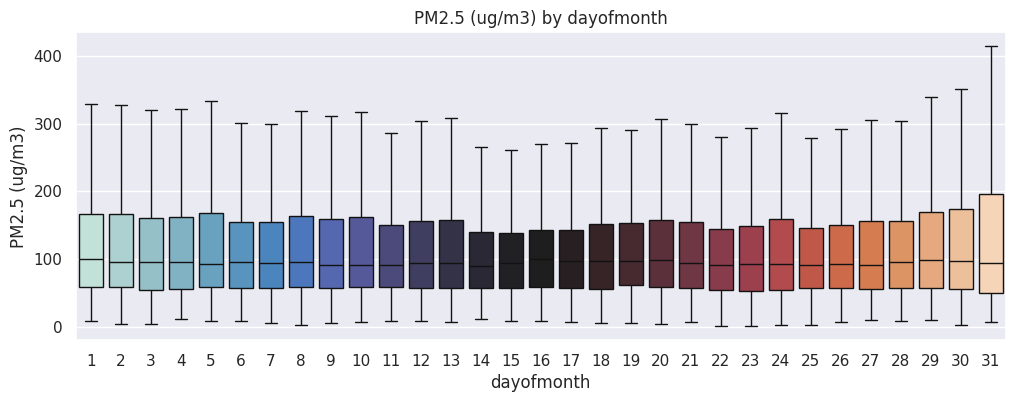

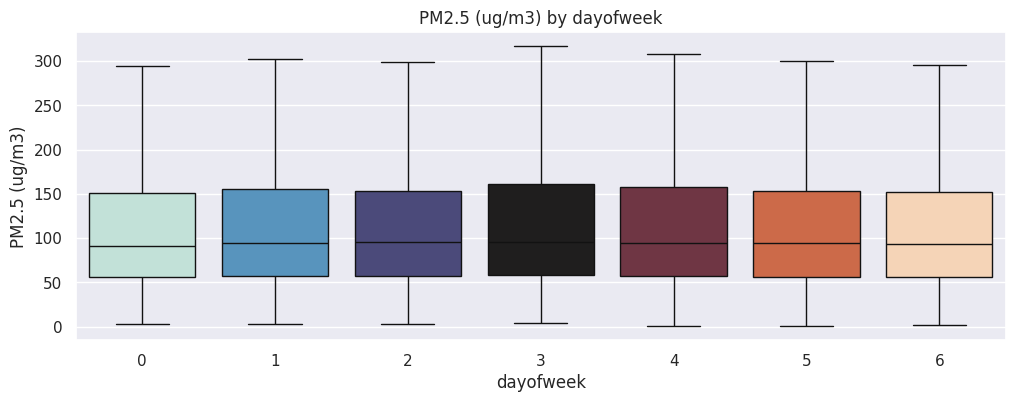

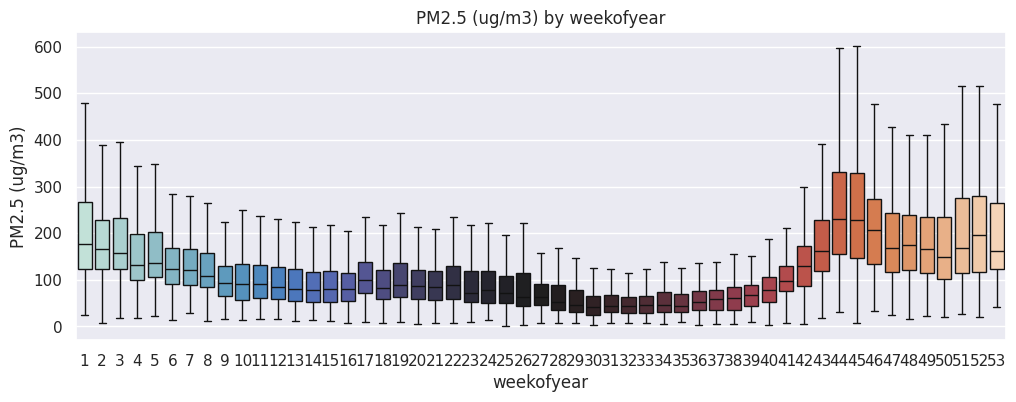

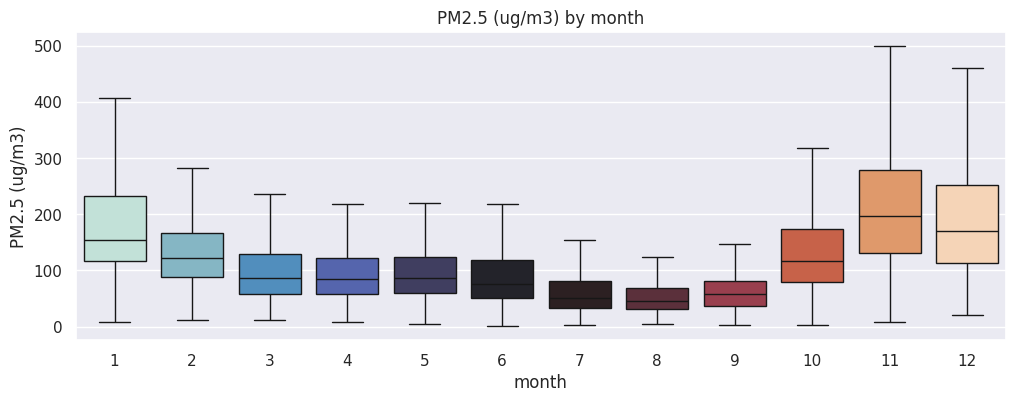

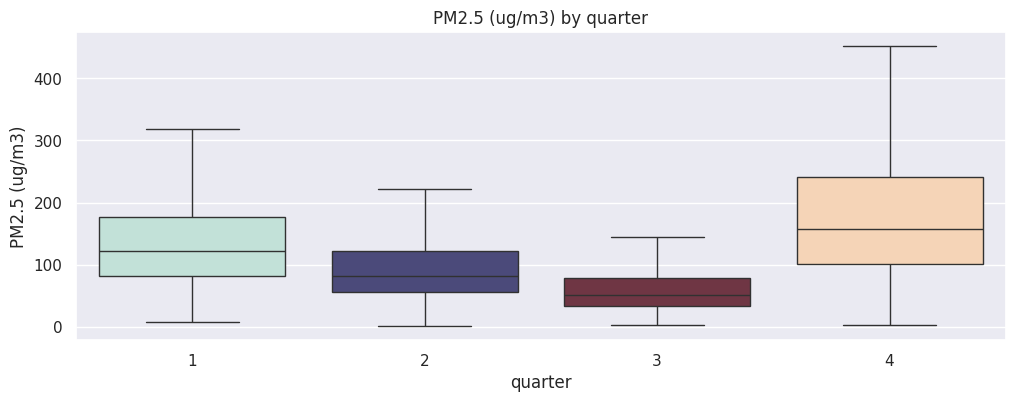

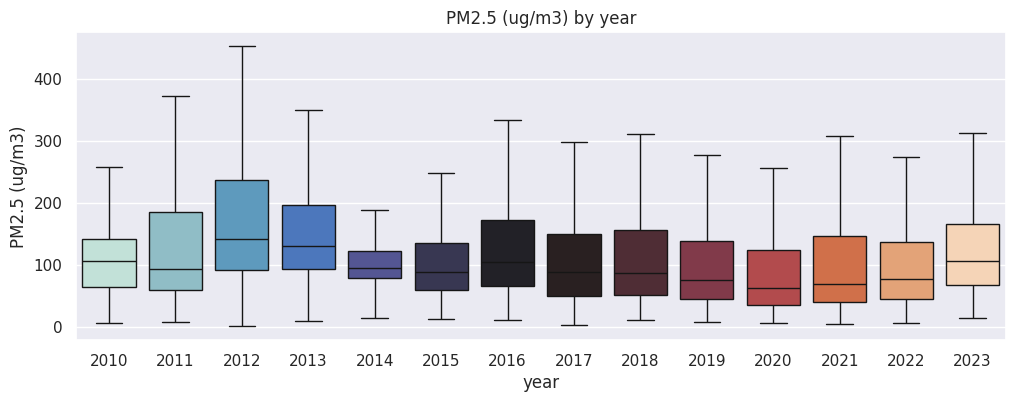

In [42]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

### Lag Features

Le cosiddette “lag features” consentono di includere nei modelli i valori storici di una variabile, risultando spesso determinanti nelle previsioni grazie al loro elevato potere predittivo. Possiamo inoltre generare lag anche per altre variabili significative, ampliando il contesto informativo del dataset e potenzialmente migliorando la precisione delle stime.

Analizzando i boxplot, abbiamo osservato che alcune feature evidenziano trend stagionali o andamenti rilevanti nel tempo. Sulla base di queste evidenze, creeremo lag features mirate per sfruttare al meglio tali pattern.

In [43]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [44]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

PM2.5 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  NOx (ug/m3)  \
datetime                                                                     
2010-01-01 00:00:00     122.496141    2.340000        26.0650      73.7425   
2010-01-01 01:00:00     122.496141    2.327500        20.3425      36.0000   
2010-01-01 02:00:00     122.496141    2.177500        11.0650      27.1900   
2010-01-01 03:00:00     122.496141    1.992500        18.4625      21.1125   
2010-01-01 04:00:00     122.496141    2.096667        13.7500      23.1550   

                     hour  dayofmonth  dayofweek  dayofyear  weekofyear  \
datetime                                                                  
2010-01-01 00:00:00     0           1          4          1          53   
2010-01-01 01:00:00     1           1          4          1          53   
2010-01-01 02:00:00     2           1          4          1          53   
2010-01-01 03:00:00     3           1          4          1          53   
2010-01-01 04:00:00     4           1          4          1          53   

                     month  quarter  year  pm_lag_1Y  pm_lag_2Y  
datetime                                                         
2010-01-01 00:00:00      1        1  2010        NaN        NaN  
2010-01-01 01:00:00      1        1  2010        NaN        NaN  
2010-01-01 02:00:00      1        1  2010        NaN        NaN  
2010-01-01 03:00:00      1        1  2010        NaN        NaN  
2010-01-01 04:00:00      1        1  2010        NaN        NaN

A seguito della creazione delle lag features, riscontriamo che i primi record del dataset presentano valori mancanti: ciò è inevitabile, dato che non esistono dati storici precedenti per calcolare i ritardi temporali. È quindi fondamentale gestire con cura questi missing values, poiché molti algoritmi predittivi non possono elaborare dati incompleti. Per affrontare questo problema, implementeremo una funzione dedicata al trattamento dei NaN generati dai lag, tenendo presente che questa operazione, pur necessaria per confrontare le performance dei modelli, potrebbe introdurre bias o comportare la perdita di informazioni nei periodi iniziali di raccolta.

In [45]:
def replace_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')

# Dataset sulla **Qualità dell'Aria in Cina**



Il dataset in questione è stato messo a disposizione dal Beijing Municipal Environmental Monitoring Center, l’ente ufficiale del Governo Cinese deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria nel distretto di Beijing nel periodo compreso tra il 2013 e il 2017.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO: monossido di carbonio (mg/m³);
- NO₂: biossido di azoto (ug/m³);
- SO₂: anidride solforosa (ug/m³);
- O3: concentrazione di Ozono (ug/m^3);
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, temperatura del punto di rugiada, precipitazioni, velocità e direzione del vento.

Unione dei vari CSV in un unico file

In [49]:
csv_folder = china_extract_to
output_file = os.path.join(china_extract_to, 'combined_dataset.csv')


csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files.")


dfs = []
for file in csv_files:
    path = os.path.join(csv_folder, file)
    try:
        df_china = pd.read_csv(path)
        dfs.append(df_china)
        print(f"Loaded {file} with {len(df_china)} rows.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded.")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined DataFrame has {len(combined_df)} rows and {len(combined_df.columns)} columns.")


combined_df.to_csv(output_file, index=False)
print(f"\nCombined CSV saved to: {output_file}")

Found 13 CSV files.
Loaded PRSA_Data_Shunyi_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Huairou_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Nongzhanguan_20130301-20170228.csv with 35064 rows.
Loaded combined_dataset.csv with 420768 rows.
Loaded PRSA_Data_Aotizhongxin_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanshouxigong_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Gucheng_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanliu_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Tiantan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Changping_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dingling_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Guanyuan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dongsi_20130301-20170228.csv with 35064 rows.

Combined DataFrame has 841536 rows and 18 columns.

Combined CSV saved to: datasets/china/combined_dataset.csv


Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [50]:
dataframe = pd.read_csv(f'{china_extract_to}/combined_dataset.csv')
dataframe.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    3.0   6.0  3.0  8.0  300.0  44.0  -0.9   
1   2  2013      3    1     1   12.0  12.0  3.0  7.0  300.0  47.0  -1.1   
2   3  2013      3    1     2   14.0  14.0  NaN  7.0  200.0  22.0  -1.7   
3   4  2013      3    1     3   12.0  12.0  3.0  5.0    NaN   NaN  -2.1   
4   5  2013      3    1     4   12.0  12.0  3.0  NaN  200.0  11.0  -2.4   

     PRES  DEWP  RAIN  wd  WSPM station  
0  1025.8 -20.5   0.0  NW   9.3  Shunyi  
1  1026.1 -21.3   0.0  NW   9.4  Shunyi  
2  1026.2 -23.0   0.0  NW   8.6  Shunyi  
3  1027.3 -23.3   0.0  NW   6.6  Shunyi  
4  1027.7 -22.9   0.0  NW   4.5  Shunyi

In [51]:
dataframe.drop(columns=['No'], inplace=True)
dataframe.head()

year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    3.0   6.0  3.0  8.0  300.0  44.0  -0.9  1025.8   
1  2013      3    1     1   12.0  12.0  3.0  7.0  300.0  47.0  -1.1  1026.1   
2  2013      3    1     2   14.0  14.0  NaN  7.0  200.0  22.0  -1.7  1026.2   
3  2013      3    1     3   12.0  12.0  3.0  5.0    NaN   NaN  -2.1  1027.3   
4  2013      3    1     4   12.0  12.0  3.0  NaN  200.0  11.0  -2.4  1027.7   

   DEWP  RAIN  wd  WSPM station  
0 -20.5   0.0  NW   9.3  Shunyi  
1 -21.3   0.0  NW   9.4  Shunyi  
2 -23.0   0.0  NW   8.6  Shunyi  
3 -23.3   0.0  NW   6.6  Shunyi  
4 -22.9   0.0  NW   4.5  Shunyi

Si crea una lista di tutti i distretti presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [52]:
unique_cities = dataframe['station'].unique()
unique_cities

array(['Shunyi', 'Huairou', 'Nongzhanguan', 'Aotizhongxin',
       'Wanshouxigong', 'Gucheng', 'Wanliu', 'Tiantan', 'Changping',
       'Dingling', 'Guanyuan', 'Dongsi'], dtype=object)

Successivamente si crea una vista del numero di entry per ogni distretto. Questo passaggio fornisce una visone dell'uniformità del quantitativo dei dati presenti in ogni distretto.

[12] different cities and [841536] total records available.


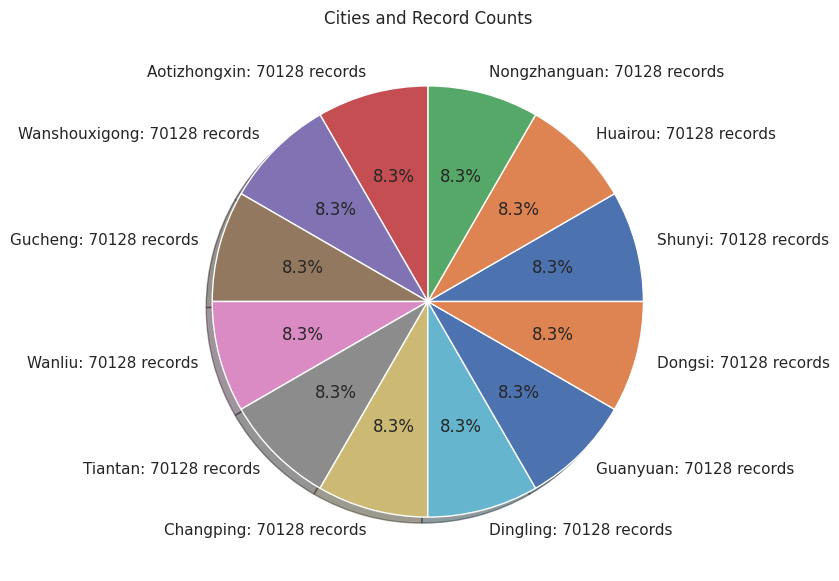

In [53]:
# Quick overview
print(f"[{dataframe['station'].nunique()}] different cities and [{dataframe['station'].count()}] total records available.")

# Get city counts
cities = dataframe["station"].value_counts()

cities.plot.pie(
    labels=[f"{c}: {p} records" for c, p in zip(cities.index, cities.values)],
    autopct="%.1f%%",
    shadow=True,
    figsize=(7,7),
    title="Cities and Record Counts"
);
plt.ylabel('');
plt.show()

Unione delle colonne temporali

In [54]:
dataframe['datetime'] = pd.to_datetime(
    dataframe[['year', 'month', 'day', 'hour']],
    errors='coerce'
)

# (Optional) Drop the original columns if you no longer need them
dataframe.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Preview the result
dataframe.head()

PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  DEWP  RAIN  wd  WSPM  \
0    3.0   6.0  3.0  8.0  300.0  44.0  -0.9  1025.8 -20.5   0.0  NW   9.3   
1   12.0  12.0  3.0  7.0  300.0  47.0  -1.1  1026.1 -21.3   0.0  NW   9.4   
2   14.0  14.0  NaN  7.0  200.0  22.0  -1.7  1026.2 -23.0   0.0  NW   8.6   
3   12.0  12.0  3.0  5.0    NaN   NaN  -2.1  1027.3 -23.3   0.0  NW   6.6   
4   12.0  12.0  3.0  NaN  200.0  11.0  -2.4  1027.7 -22.9   0.0  NW   4.5   

  station            datetime  
0  Shunyi 2013-03-01 00:00:00  
1  Shunyi 2013-03-01 01:00:00  
2  Shunyi 2013-03-01 02:00:00  
3  Shunyi 2013-03-01 03:00:00  
4  Shunyi 2013-03-01 04:00:00

## Pre-elaborazione dei dati

#### Utilizzo di ‘datetime’ come indice temporale

Per gestire efficacemente le serie storiche, viene utilizzata la colonna `datetime` come indice datetime.

In [55]:
dataframe = dataframe.rename(columns={'station': 'District'})
dataframe = dataframe.set_index('datetime')
dataframe.head()

PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  DEWP  \
datetime                                                                      
2013-03-01 00:00:00    3.0   6.0  3.0  8.0  300.0  44.0  -0.9  1025.8 -20.5   
2013-03-01 01:00:00   12.0  12.0  3.0  7.0  300.0  47.0  -1.1  1026.1 -21.3   
2013-03-01 02:00:00   14.0  14.0  NaN  7.0  200.0  22.0  -1.7  1026.2 -23.0   
2013-03-01 03:00:00   12.0  12.0  3.0  5.0    NaN   NaN  -2.1  1027.3 -23.3   
2013-03-01 04:00:00   12.0  12.0  3.0  NaN  200.0  11.0  -2.4  1027.7 -22.9   

                     RAIN  wd  WSPM District  
datetime                                      
2013-03-01 00:00:00   0.0  NW   9.3   Shunyi  
2013-03-01 01:00:00   0.0  NW   9.4   Shunyi  
2013-03-01 02:00:00   0.0  NW   8.6   Shunyi  
2013-03-01 03:00:00   0.0  NW   6.6   Shunyi  
2013-03-01 04:00:00   0.0  NW   4.5   Shunyi

### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [56]:
dataframe.isnull().sum().sort_values(ascending=False)


CO          41402
O3          26554
NO2         24232
SO2         18042
PM2.5       17478
PM10        12898
wd           3644
DEWP          806
TEMP          796
PRES          786
RAIN          780
WSPM          636
District        0
dtype: int64

In [57]:
df_china=dataframe
df_china = df_china.dropna(how='all')
df_china = df_china.dropna(how='all', axis='columns')

In [58]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

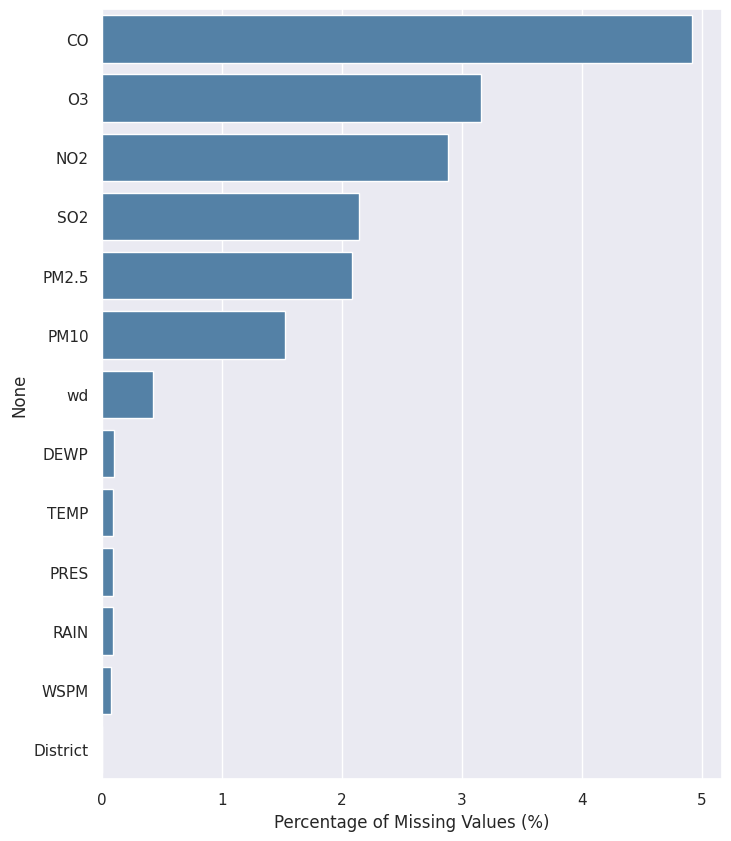

In [59]:
df_null_info = get_null_info(df_china)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percentage of Missing Values (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Non essendoci colonne al di sopra di una certa soglia (>40%) non viene eliminato nulla.

### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [60]:
pollutants = {
    'Particulate Matter' : ['PM2.5', 'PM10'],
    'Nitrogen Compounds' : ['NO2'],
    'Carbon Monoxide': ['CO'],
    'Sulfur Dioxide': ['SO2'],
    'Ozone Concentration' : ['O3']
}
other_metrics = {
    'Pressure' : ['PRES'],
    'Temperatures' : ['TEMP'],
    'Dew Point Temperature' : ['DEWP'],
    'Rainfall' : ['RAIN'],
    'Wind Direction' : ['wd'],
    'Wind Speed' : ['WSPM']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [61]:
slice_groups = {
    'Group by Day':   df_china.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df_china.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df_china.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [62]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]



            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

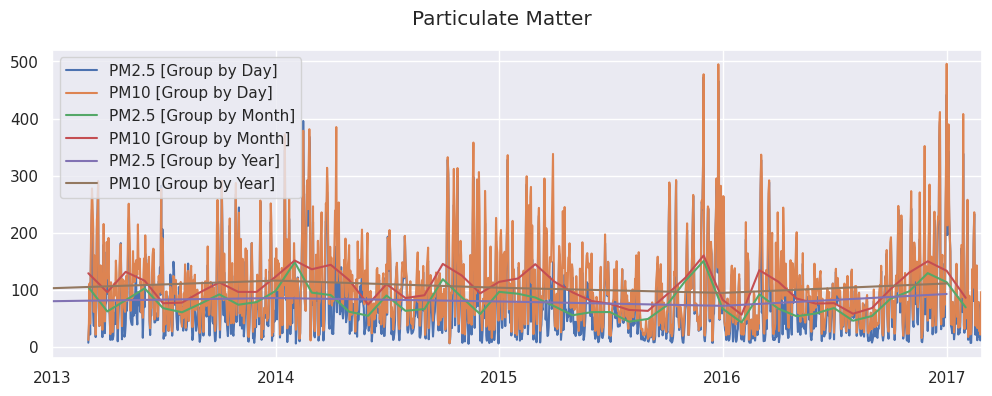

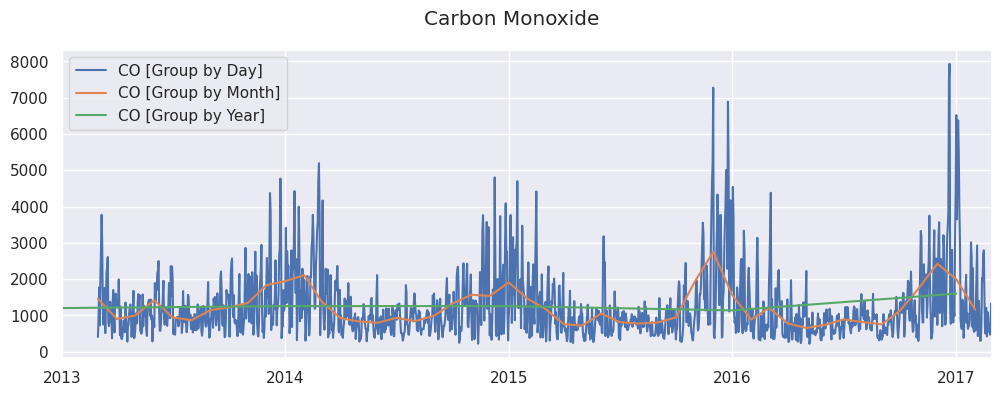

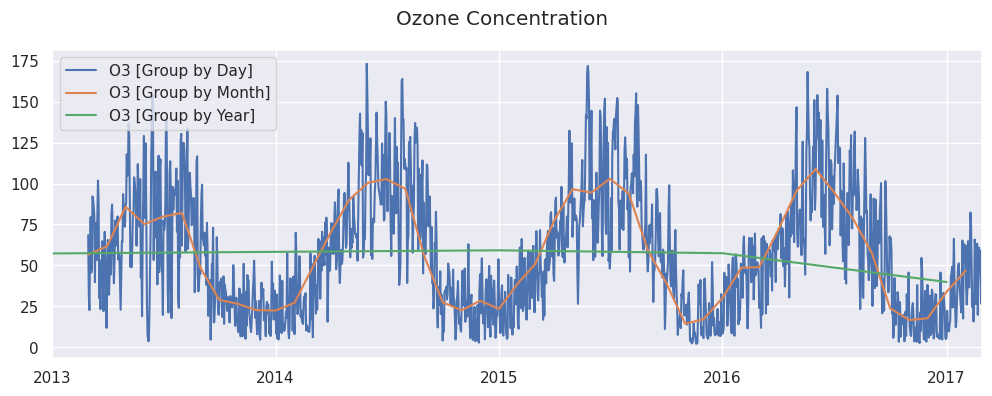

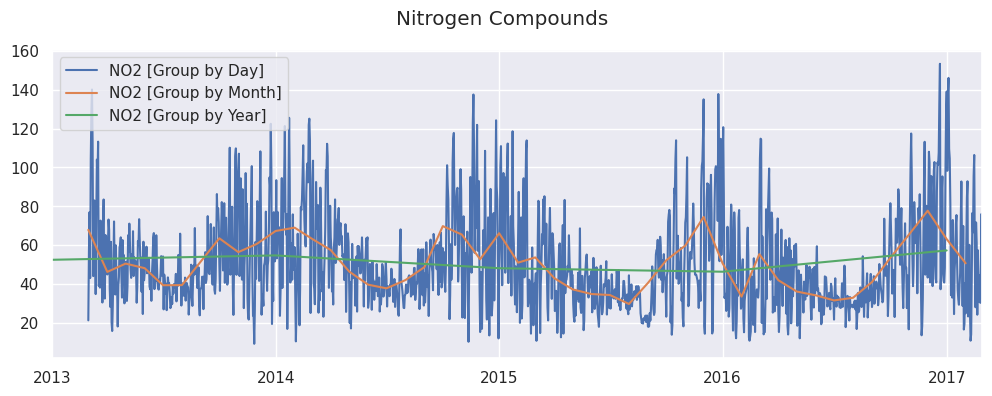

In [63]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2016–2017.

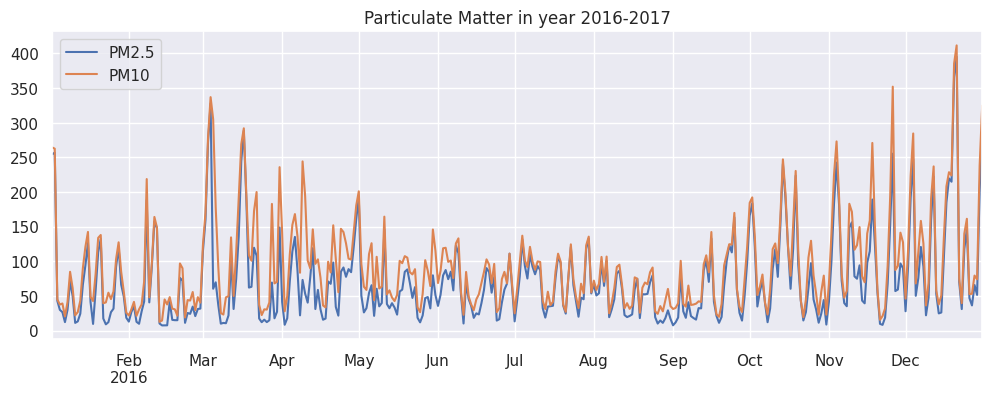

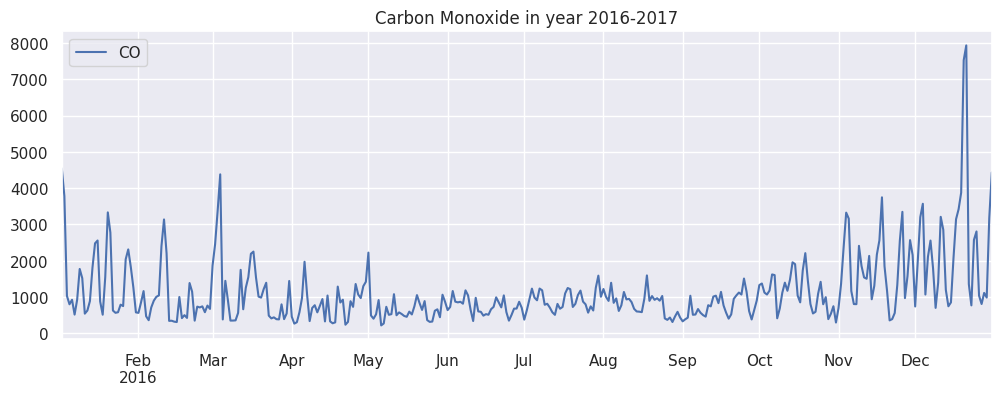

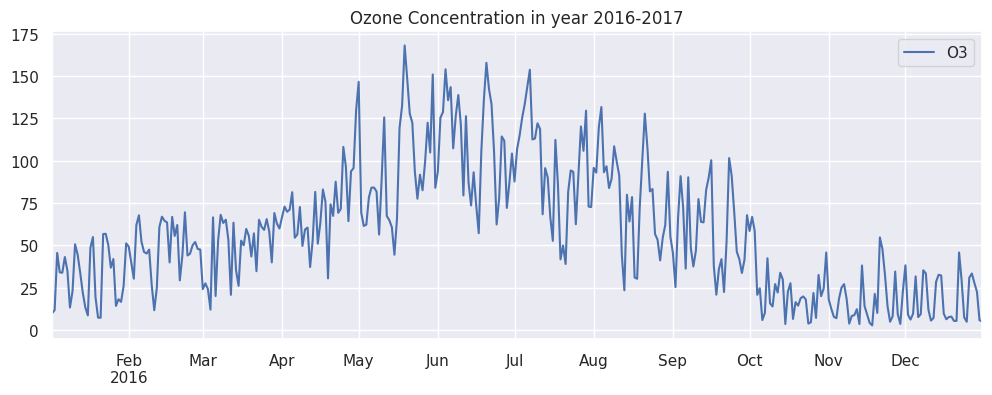

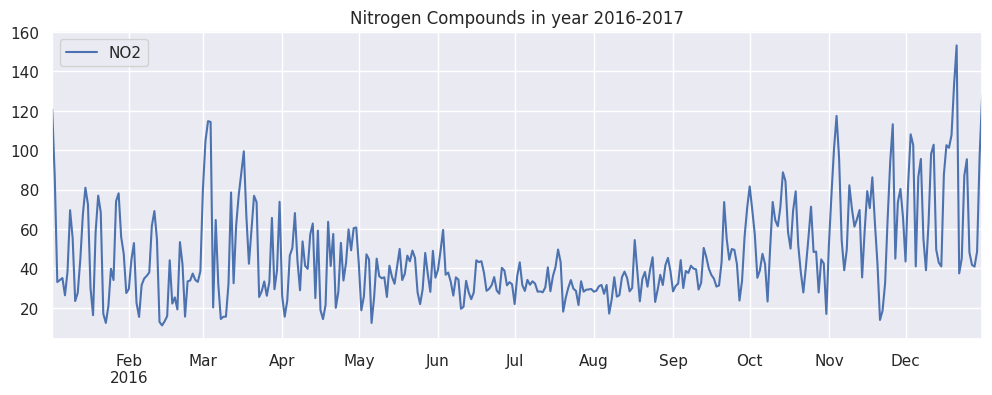

In [64]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2016 and datetime < 2017').plot(title=f'{feature} in year 2016-2017', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

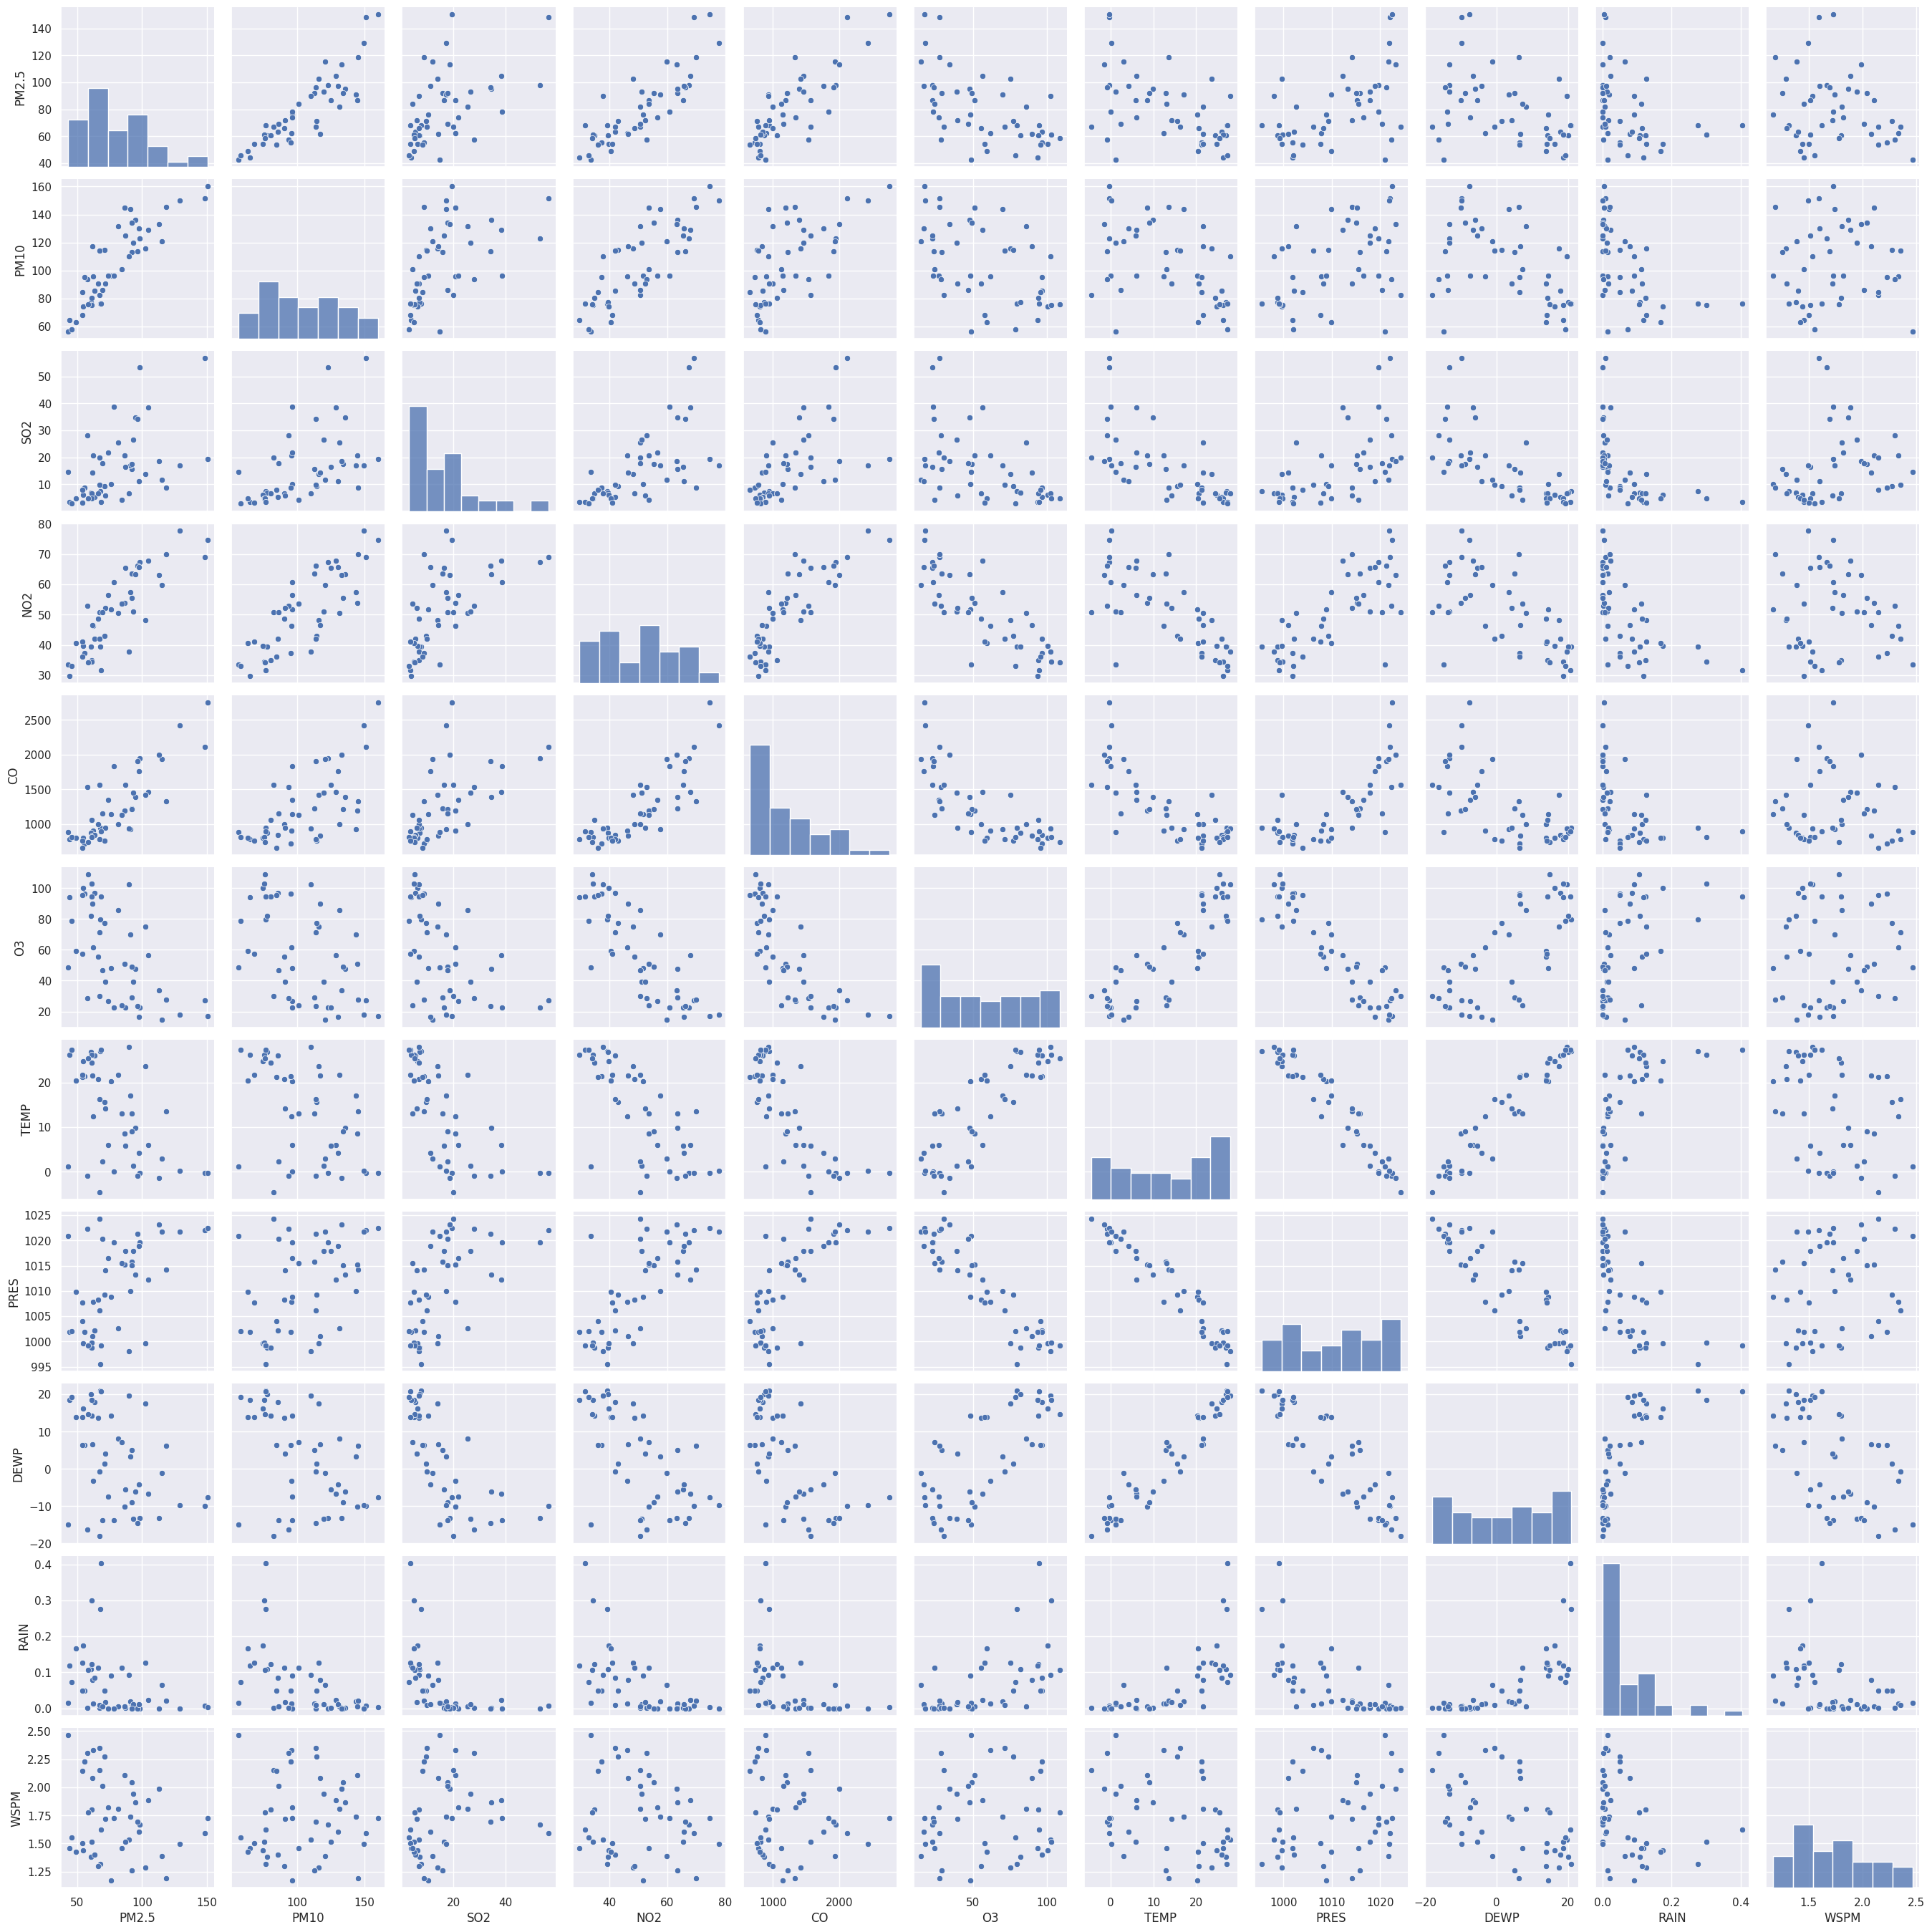

In [65]:
sns.pairplot(slice_groups['Group by Month'])

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

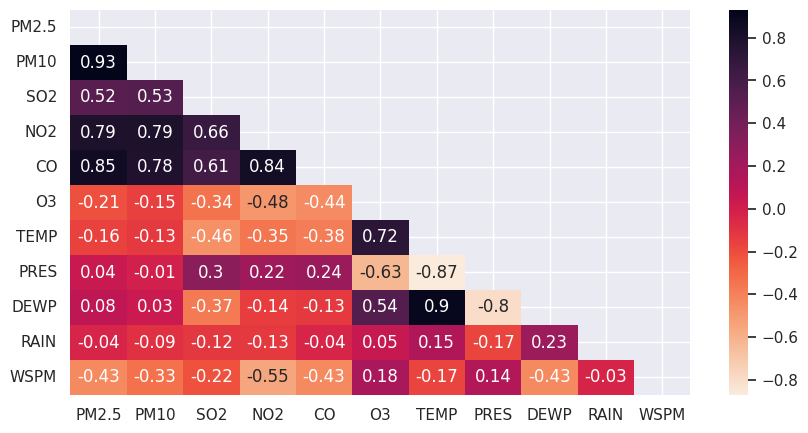

In [66]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [67]:
corr_target = abs(corr['PM2.5'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5    1.00
PM10     0.93
CO       0.85
NO2      0.79
SO2      0.52
WSPM     0.43
Name: PM2.5, dtype: float64

Il grafico evidenzia diverse correlazioni significative tra le variabili.

Vengono raggruppare le direzioni cardinali del vento mostrando la loro influenza sulla concentrazione di PM2.5

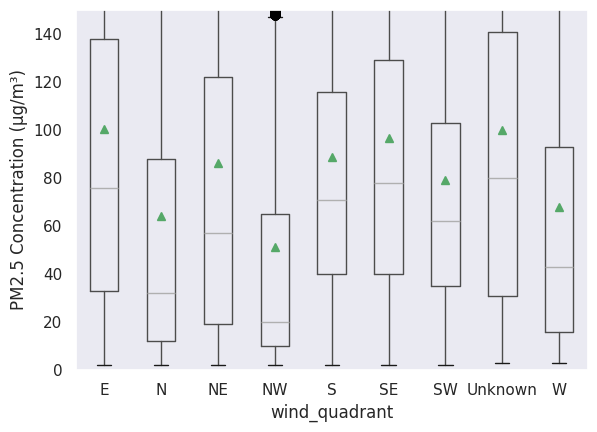

In [68]:
# Apply to the dataframe
def wind_quadrant_str(direction):
    if pd.isna(direction):
        return "Unknown"
    direction = direction.upper()

    if direction in ['N', 'NNE', 'NNW']:
        return "N"
    elif direction in ['NE']:
        return "NE"
    elif direction in ['E', 'ENE', 'ESE']:
        return "E"
    elif direction in ['NW']:
        return "NW"
    elif direction in ['S', 'SSE', 'SSW']:
        return "S"
    elif direction in ['SE']:
        return "SE"
    elif direction in ['W', 'WNW', 'WSW']:
        return "W"
    elif direction in ['SW']:
        return "SW"
    else:
        return "Other"

# Apply to the dataframe
dataframe["wind_quadrant"] = dataframe["wd"].apply(wind_quadrant_str)

# Boxplot
ax = dataframe.boxplot(
    column="PM2.5",
    by="wind_quadrant",
    showmeans=True,
    grid=False
)
ax.set_ylabel("PM2.5 Concentration (µg/m³)")
ax.set_title("")
plt.suptitle("")
plt.ylim(0, 150)
plt.show()


## Feature Engineering



### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [69]:
df_china = df_china.resample('60min').mean(numeric_only=True)

### Isolation Forest - Rilevamento e Rimozione degli Outlier
Utilizzeremo l'algoritmo Isolation Forest per identificare e rimuovere automaticamente gli outlier dalle nostre quattro variabili ambientali.

Definiamo le colonne su cui applicheremo Isolation Forest: `PM2.5`, `CO`, `O3` e `NO2`.

In [70]:
features = ['PM2.5', 'CO', 'O3', 'NO2']
df_china_features = df_china[features].copy()

Impostiamo il parametro `contamination` in base alla percentuale di outlier attesa (qui 1%).

In [71]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df_china_features)

IsolationForest(contamination=0.01, random_state=42)

Con `predict`, i valori anomali vengono etichettati con -1, quelli normali con +1.

In [72]:
df_china['anomaly'] = iso.predict(df_china_features)

Creiamo un nuovo DataFrame `df_clean` escludendo tutte le righe etichettate come outlier.

In [73]:
df_china_clean = df_china[df_china['anomaly'] == 1].drop(columns='anomaly')

Confrontiamo le distribuzioni originali e quelle ripulite per ciascuna variabile.

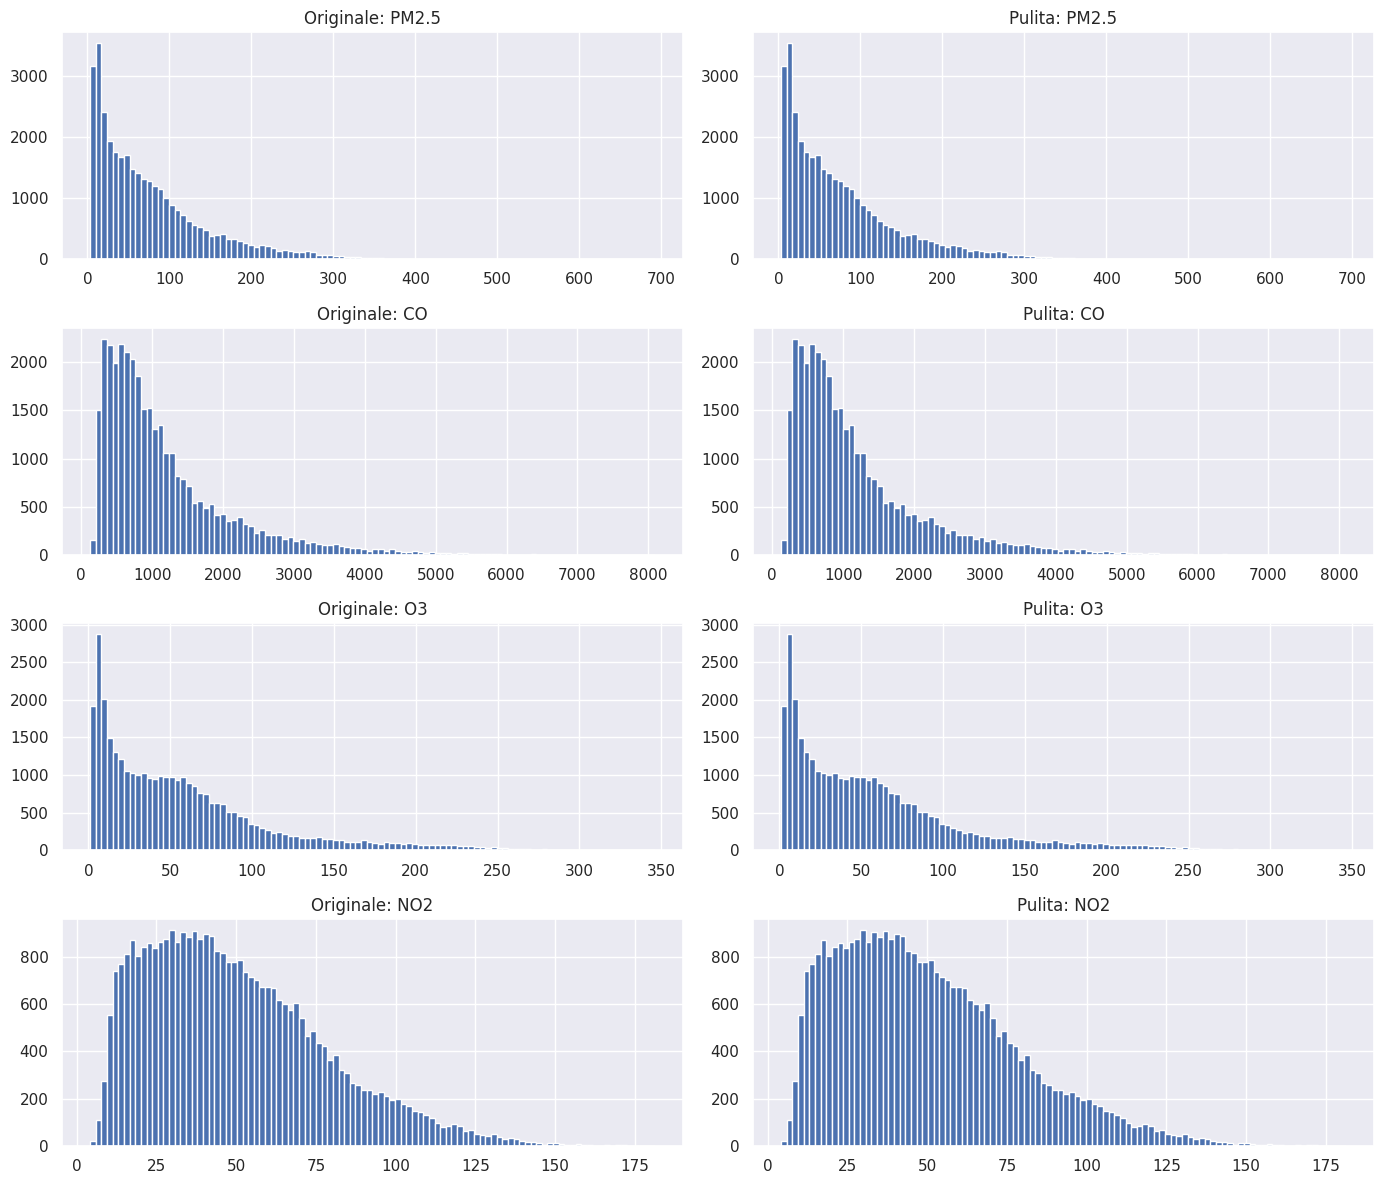

In [85]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for i, col in enumerate(features):
    # istogramma dati originali
    axes[i, 0].hist(df_china[col].dropna(), bins=100)
    axes[i, 0].set_title(f"Originale: {col}")
    # istogramma dati puliti
    axes[i, 1].hist(df_china_clean[col].dropna(), bins=100)
    axes[i, 1].set_title(f"Pulita: {col}")
plt.tight_layout()
plt.show()

df_china = df_china_clean.copy()

### Gestione dei valori mancanti

In [86]:
get_null_info(df_china)

Null Count  Percentage of Missing Values (%)
CO            204                              0.59
O3            106                              0.31
SO2            87                              0.25
NO2            87                              0.25
PM10           83                              0.24
PM2.5          81                              0.23
TEMP           18                              0.05
PRES           18                              0.05
DEWP           18                              0.05
RAIN           18                              0.05
WSPM           12                              0.03

In [87]:
df_china = df_china.interpolate(method='pad')
df_china = df_china.fillna(df_china.mean())
df_china.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34713 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   34713 non-null  float64
 1   PM10    34713 non-null  float64
 2   SO2     34713 non-null  float64
 3   NO2     34713 non-null  float64
 4   CO      34713 non-null  float64
 5   O3      34713 non-null  float64
 6   TEMP    34713 non-null  float64
 7   PRES    34713 non-null  float64
 8   DEWP    34713 non-null  float64
 9   RAIN    34713 non-null  float64
 10  WSPM    34713 non-null  float64
dtypes: float64(11)
memory usage: 3.2 MB


<ipython-input-87-55c50d9aa9fb>:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_china = df_china.interpolate(method='pad')


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [88]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [89]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df_china = create_features(df_china)

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [90]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_china, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

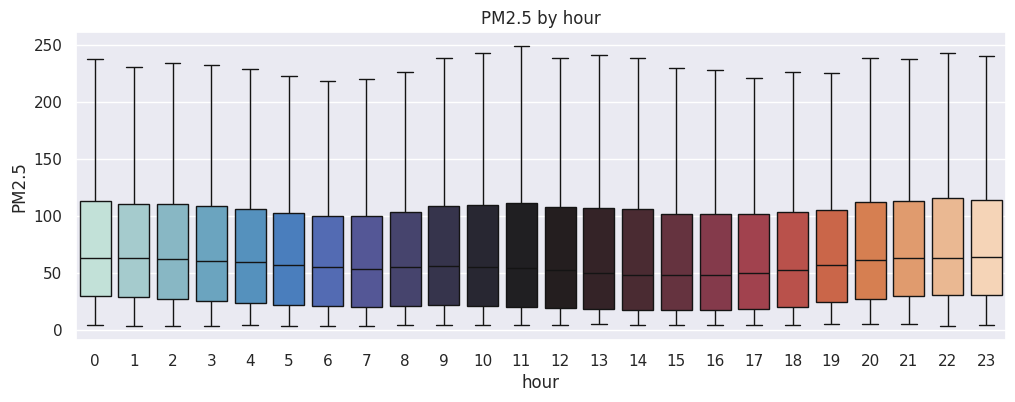

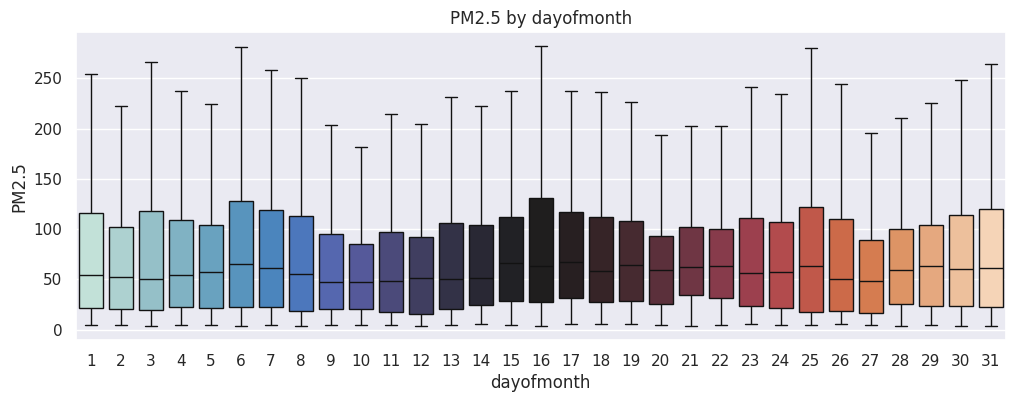

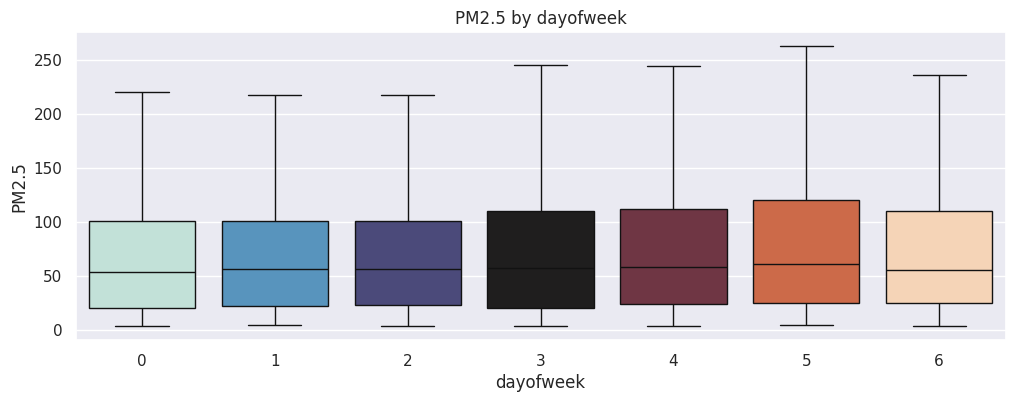

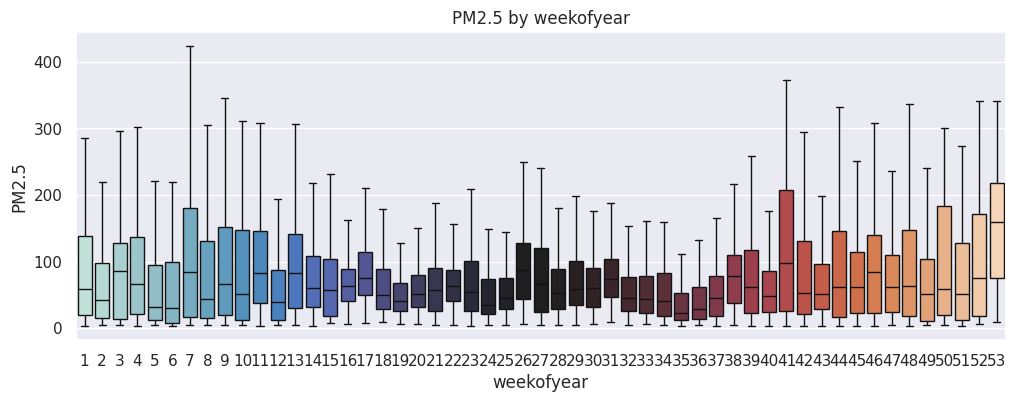

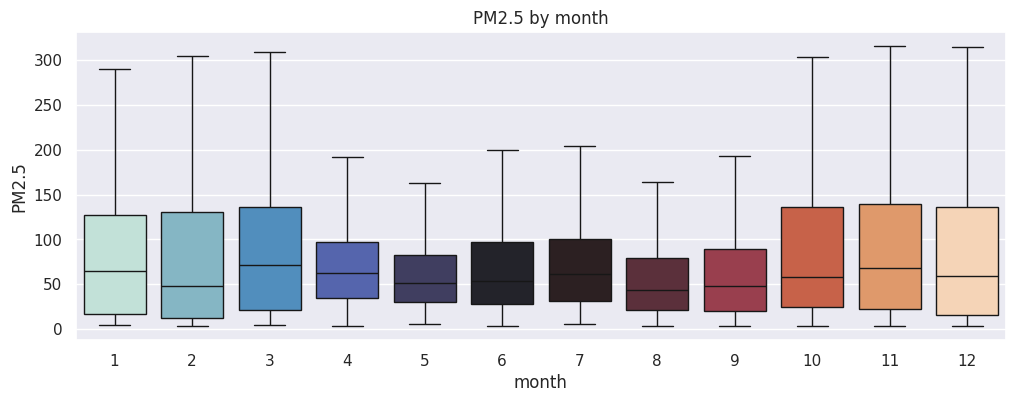

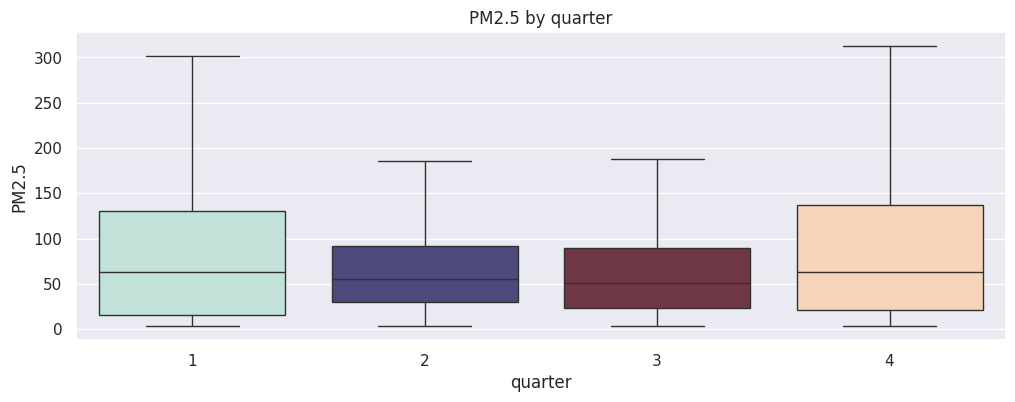

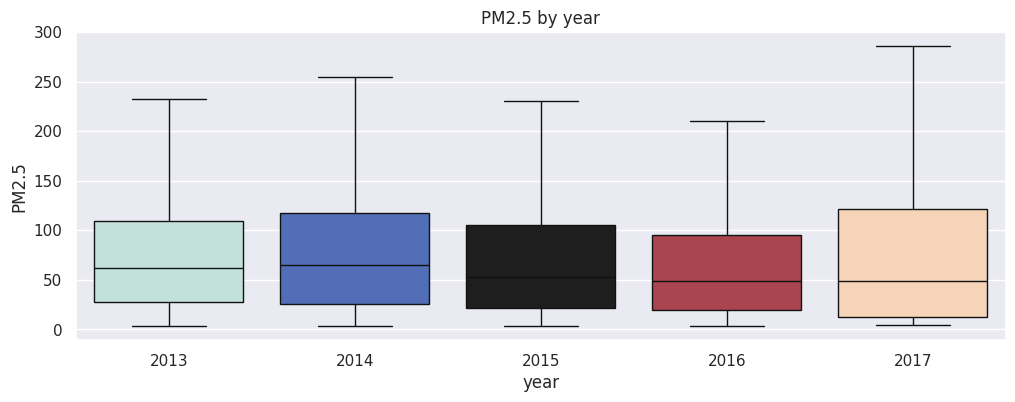

In [91]:
plot_by_datetime('PM2.5', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

### Lag Features

Le cosiddette “lag features” consentono di includere nei modelli i valori storici di una variabile, risultando spesso determinanti nelle previsioni grazie al loro elevato potere predittivo. Possiamo inoltre generare lag anche per altre variabili significative, ampliando il contesto informativo del dataset e potenzialmente migliorando la precisione delle stime.

Analizzando i boxplot, abbiamo osservato che alcune feature evidenziano trend stagionali o andamenti rilevanti nel tempo. Sulla base di queste evidenze, creeremo lag features mirate per sfruttare al meglio tali pattern.

In [92]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5'].shift(730*24)   # 2 year lag
    return df

In [93]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df_china = create_lag_features(df_china)
df_china.head()

PM2.5      PM10       SO2        NO2          CO  \
datetime                                                                   
2013-03-01 00:00:00  5.666667  7.916667  5.666667  12.600000  308.333333   
2013-03-01 01:00:00  6.833333  9.833333  5.333333  13.111111  308.333333   
2013-03-01 02:00:00  5.666667  7.250000  8.166667  12.900000  300.000000   
2013-03-01 03:00:00  6.000000  9.250000  5.833333  12.400000  283.333333   
2013-03-01 04:00:00  4.833333  6.916667  6.750000  14.000000  308.333333   

                            O3      TEMP         PRES       DEWP  RAIN  ...  \
datetime                                                                ...   
2013-03-01 00:00:00  75.416667 -0.916667  1022.766667 -19.900000   0.0  ...   
2013-03-01 01:00:00  75.750000 -1.216667  1023.191667 -19.916667   0.0  ...   
2013-03-01 02:00:00  66.000000 -1.591667  1023.325000 -21.008333   0.0  ...   
2013-03-01 03:00:00  75.333333 -1.891667  1024.208333 -21.833333   0.0  ...   
2013-03-01 04:00:00  66.333333 -2.283333  1024.866667 -21.625000   0.0  ...   

                     hour  dayofmonth  dayofweek  dayofyear  weekofyear  \
datetime                                                                  
2013-03-01 00:00:00     0           1          4         60           9   
2013-03-01 01:00:00     1           1          4         60           9   
2013-03-01 02:00:00     2           1          4         60           9   
2013-03-01 03:00:00     3           1          4         60           9   
2013-03-01 04:00:00     4           1          4         60           9   

                     month  quarter  year  pm_lag_1Y  pm_lag_2Y  
datetime                                                         
2013-03-01 00:00:00      3        1  2013        NaN        NaN  
2013-03-01 01:00:00      3        1  2013        NaN        NaN  
2013-03-01 02:00:00      3        1  2013        NaN        NaN  
2013-03-01 03:00:00      3        1  2013        NaN        NaN  
2013-03-01 04:00:00      3        1  2013        NaN        NaN  

[5 rows x 21 columns]

A seguito della creazione delle lag features, riscontriamo che i primi record del dataset presentano valori mancanti: ciò è inevitabile, dato che non esistono dati storici precedenti per calcolare i ritardi temporali. È quindi fondamentale gestire con cura questi missing values, poiché molti algoritmi predittivi non possono elaborare dati incompleti. Per affrontare questo problema, implementeremo una funzione dedicata al trattamento dei NaN generati dai lag, tenendo presente che questa operazione, pur necessaria per confrontare le performance dei modelli, potrebbe introdurre bias o comportare la perdita di informazioni nei periodi iniziali di raccolta.

In [94]:
def replace_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')